In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

In [2]:
patch_size = 56
batch_size = 128
latent_dim = 128

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches  -- tensor of stacked patches    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches = []
    
    for file_patch in files_patches:
        patch = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patches.append(patch)
        
    patches = np.array(patches)
    patches = patches.astype(np.float64) / 255
    patches = np.expand_dims(patches, -1)
        
    print("patches shape:", patches.shape)
    
    return patches

In [5]:
x_train = loading_data(train_data_dir)
x_validation = loading_data(validation_data_dir)

patches shape: (64598, 56, 56, 1)
patches shape: (8075, 56, 56, 1)


In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
encoder_inputs = keras.Input(shape=(patch_size, patch_size, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 56, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              404544    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 56, 56, 1)         289 

In [115]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
#             print(data.shape)
#             print(data[0])
#             print(type(data))
#             print(type(data[0]))
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = 10 * reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [116]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [35]:
# vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))  # change lr from 0.001 (default) to 0.0001

In [117]:
model_version_old = "0.0.1.1_reconstrweight5"
vae.load_weights(base_dir + '/vae_' + model_version_old + '.h5')

Epoch 6400/6400
505/505  - 6s 11ms/step - loss: 619.6827 - reconstruction_loss: 411.9737 - kl_loss: 1.7221

In [118]:
model_version = "0.0.1.2_reconstrweight10"
os.system('mkdir ' + base_dir + '/weights_vae_' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights_vae_' + model_version + '/weights.{epoch:02d}-{loss:.2f}.h5', monitor='loss',
    verbose=0, save_best_only=False, save_weights_only=True, mode='auto', save_freq=505)


history_callback = vae.fit(x_train, epochs=50 * batch_size, batch_size=batch_size)


vae.save_weights(base_dir + '/vae_' + model_version + '.h5')

Epoch 1/6400
505/505 [==============================] - 5s 11ms/step - loss: 4120.9226 - reconstruction_loss: 411.8320 - kl_loss: 2.6029
Epoch 2/6400
505/505 [==============================] - 5s 11ms/step - loss: 4119.1905 - reconstruction_loss: 411.6576 - kl_loss: 2.6145
Epoch 3/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0045 - reconstruction_loss: 411.7387 - kl_loss: 2.6172
Epoch 4/6400
505/505 [==============================] - 5s 11ms/step - loss: 4119.7601 - reconstruction_loss: 411.7141 - kl_loss: 2.6189
Epoch 5/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9624 - reconstruction_loss: 411.7341 - kl_loss: 2.6218
Epoch 6/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7503 - reconstruction_loss: 411.7126 - kl_loss: 2.6242
Epoch 7/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7509 - reconstruction_loss: 411.7123 - kl_loss: 2.6278
Epoch 8/6400
505/505 [===================

505/505 [==============================] - 6s 11ms/step - loss: 4119.3238 - reconstruction_loss: 411.6676 - kl_loss: 2.6479
Epoch 61/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5701 - reconstruction_loss: 411.6920 - kl_loss: 2.6502
Epoch 62/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1133 - reconstruction_loss: 411.6466 - kl_loss: 2.6470
Epoch 63/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6647 - reconstruction_loss: 411.7016 - kl_loss: 2.6487
Epoch 64/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8619 - reconstruction_loss: 411.7214 - kl_loss: 2.6479
Epoch 65/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2563 - reconstruction_loss: 411.6608 - kl_loss: 2.6485
Epoch 66/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6596 - reconstruction_loss: 411.7011 - kl_loss: 2.6488
Epoch 67/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 4119.1307 - reconstruction_loss: 411.6474 - kl_loss: 2.6569
Epoch 120/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7541 - reconstruction_loss: 411.7098 - kl_loss: 2.6562
Epoch 121/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6856 - reconstruction_loss: 411.7032 - kl_loss: 2.6540
Epoch 122/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9830 - reconstruction_loss: 411.7327 - kl_loss: 2.6563
Epoch 123/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7226 - reconstruction_loss: 411.7066 - kl_loss: 2.6566
Epoch 124/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7676 - reconstruction_loss: 411.7113 - kl_loss: 2.6548
Epoch 125/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9468 - reconstruction_loss: 411.7291 - kl_loss: 2.6557
Epoch 126/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 4119.7929 - reconstruction_loss: 411.7131 - kl_loss: 2.6615
Epoch 179/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2052 - reconstruction_loss: 411.6543 - kl_loss: 2.6620
Epoch 180/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3894 - reconstruction_loss: 411.6730 - kl_loss: 2.6594
Epoch 181/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.1147 - reconstruction_loss: 411.7455 - kl_loss: 2.6592
Epoch 182/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4280 - reconstruction_loss: 411.6768 - kl_loss: 2.6601
Epoch 183/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4317 - reconstruction_loss: 411.6770 - kl_loss: 2.6612
Epoch 184/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5299 - reconstruction_loss: 411.6868 - kl_loss: 2.6617
Epoch 185/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 4119.1469 - reconstruction_loss: 411.6484 - kl_loss: 2.6629
Epoch 238/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8254 - reconstruction_loss: 411.7164 - kl_loss: 2.6611
Epoch 239/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3058 - reconstruction_loss: 411.6641 - kl_loss: 2.6645
Epoch 240/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1308 - reconstruction_loss: 411.6467 - kl_loss: 2.6636
Epoch 241/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4626 - reconstruction_loss: 411.6801 - kl_loss: 2.6621
Epoch 242/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5063 - reconstruction_loss: 411.6844 - kl_loss: 2.6619
Epoch 243/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2347 - reconstruction_loss: 411.6572 - kl_loss: 2.6632
Epoch 244/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 4119.8449 - reconstruction_loss: 411.7179 - kl_loss: 2.6662
Epoch 297/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9990 - reconstruction_loss: 411.7332 - kl_loss: 2.6671
Epoch 298/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3296 - reconstruction_loss: 411.6666 - kl_loss: 2.6640
Epoch 299/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5053 - reconstruction_loss: 411.6837 - kl_loss: 2.6681
Epoch 300/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4428 - reconstruction_loss: 411.6777 - kl_loss: 2.6655
Epoch 301/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8195 - reconstruction_loss: 411.7154 - kl_loss: 2.6654
Epoch 302/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7498 - reconstruction_loss: 411.7084 - kl_loss: 2.6661
Epoch 303/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 4119.4050 - reconstruction_loss: 411.6737 - kl_loss: 2.6676
Epoch 356/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.3246 - reconstruction_loss: 411.7657 - kl_loss: 2.6676
Epoch 357/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8886 - reconstruction_loss: 411.7220 - kl_loss: 2.6683
Epoch 358/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3300 - reconstruction_loss: 411.6663 - kl_loss: 2.6672
Epoch 359/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2207 - reconstruction_loss: 411.6554 - kl_loss: 2.6670
Epoch 360/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3957 - reconstruction_loss: 411.6730 - kl_loss: 2.6659
Epoch 361/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0169 - reconstruction_loss: 411.6348 - kl_loss: 2.6690
Epoch 362/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 4119.3902 - reconstruction_loss: 411.6721 - kl_loss: 2.6692
Epoch 415/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9909 - reconstruction_loss: 411.7323 - kl_loss: 2.6682
Epoch 416/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4647 - reconstruction_loss: 411.6795 - kl_loss: 2.6694
Epoch 417/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.9671 - reconstruction_loss: 411.6299 - kl_loss: 2.6681
Epoch 418/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0964 - reconstruction_loss: 411.6428 - kl_loss: 2.6679
Epoch 419/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9711 - reconstruction_loss: 411.7300 - kl_loss: 2.6713
Epoch 420/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1124 - reconstruction_loss: 411.6441 - kl_loss: 2.6713
Epoch 421/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 4119.3043 - reconstruction_loss: 411.6633 - kl_loss: 2.6712
Epoch 474/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4286 - reconstruction_loss: 411.6757 - kl_loss: 2.6712
Epoch 475/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6410 - reconstruction_loss: 411.6971 - kl_loss: 2.6703
Epoch 476/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6557 - reconstruction_loss: 411.6984 - kl_loss: 2.6715
Epoch 477/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5848 - reconstruction_loss: 411.6915 - kl_loss: 2.6701
Epoch 478/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4456 - reconstruction_loss: 411.6775 - kl_loss: 2.6702
Epoch 479/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6757 - reconstruction_loss: 411.7005 - kl_loss: 2.6708
Epoch 480/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 4120.0370 - reconstruction_loss: 411.7366 - kl_loss: 2.6714
Epoch 533/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6570 - reconstruction_loss: 411.6984 - kl_loss: 2.6726
Epoch 534/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4940 - reconstruction_loss: 411.6821 - kl_loss: 2.6734
Epoch 535/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6158 - reconstruction_loss: 411.6942 - kl_loss: 2.6736
Epoch 536/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6447 - reconstruction_loss: 411.6970 - kl_loss: 2.6749
Epoch 537/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5905 - reconstruction_loss: 411.6918 - kl_loss: 2.6727
Epoch 538/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4266 - reconstruction_loss: 411.6754 - kl_loss: 2.6729
Epoch 539/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 4120.0187 - reconstruction_loss: 411.7344 - kl_loss: 2.6745
Epoch 592/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9084 - reconstruction_loss: 411.7237 - kl_loss: 2.6718
Epoch 593/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8465 - reconstruction_loss: 411.7173 - kl_loss: 2.6735
Epoch 594/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0449 - reconstruction_loss: 411.7372 - kl_loss: 2.6726
Epoch 595/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3400 - reconstruction_loss: 411.6665 - kl_loss: 2.6747
Epoch 596/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8535 - reconstruction_loss: 411.6180 - kl_loss: 2.6733
Epoch 597/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7875 - reconstruction_loss: 411.7114 - kl_loss: 2.6733
Epoch 598/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 4119.5370 - reconstruction_loss: 411.6863 - kl_loss: 2.6743
Epoch 651/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5460 - reconstruction_loss: 411.6870 - kl_loss: 2.6755
Epoch 652/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7204 - reconstruction_loss: 411.7044 - kl_loss: 2.6760
Epoch 653/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6447 - reconstruction_loss: 411.6970 - kl_loss: 2.6751
Epoch 654/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2631 - reconstruction_loss: 411.6587 - kl_loss: 2.6764
Epoch 655/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5132 - reconstruction_loss: 411.6839 - kl_loss: 2.6746
Epoch 656/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3294 - reconstruction_loss: 411.6656 - kl_loss: 2.6734
Epoch 657/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 4119.8613 - reconstruction_loss: 411.7187 - kl_loss: 2.6743
Epoch 710/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6416 - reconstruction_loss: 411.6965 - kl_loss: 2.6762
Epoch 711/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7250 - reconstruction_loss: 411.7049 - kl_loss: 2.6763
Epoch 712/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1873 - reconstruction_loss: 411.6514 - kl_loss: 2.6735
Epoch 713/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3800 - reconstruction_loss: 411.6704 - kl_loss: 2.6760
Epoch 714/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5493 - reconstruction_loss: 411.6874 - kl_loss: 2.6756
Epoch 715/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4713 - reconstruction_loss: 411.6798 - kl_loss: 2.6737
Epoch 716/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 4119.5650 - reconstruction_loss: 411.6890 - kl_loss: 2.6751
Epoch 769/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9993 - reconstruction_loss: 411.7323 - kl_loss: 2.6767
Epoch 770/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1049 - reconstruction_loss: 411.6429 - kl_loss: 2.6763
Epoch 771/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2604 - reconstruction_loss: 411.6581 - kl_loss: 2.6793
Epoch 772/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.3941 - reconstruction_loss: 411.7721 - kl_loss: 2.6734
Epoch 773/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5185 - reconstruction_loss: 411.6840 - kl_loss: 2.6781
Epoch 774/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1468 - reconstruction_loss: 411.6471 - kl_loss: 2.6762
Epoch 775/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 4119.6222 - reconstruction_loss: 411.6947 - kl_loss: 2.6755
Epoch 828/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0253 - reconstruction_loss: 411.7350 - kl_loss: 2.6749
Epoch 829/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0644 - reconstruction_loss: 411.6387 - kl_loss: 2.6778
Epoch 830/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6136 - reconstruction_loss: 411.6936 - kl_loss: 2.6779
Epoch 831/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5091 - reconstruction_loss: 411.6832 - kl_loss: 2.6773
Epoch 832/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9478 - reconstruction_loss: 411.7270 - kl_loss: 2.6780
Epoch 833/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8951 - reconstruction_loss: 411.6218 - kl_loss: 2.6768
Epoch 834/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 4119.5091 - reconstruction_loss: 411.6832 - kl_loss: 2.6772
Epoch 887/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3466 - reconstruction_loss: 411.6668 - kl_loss: 2.6788
Epoch 888/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0146 - reconstruction_loss: 411.7339 - kl_loss: 2.6757
Epoch 889/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4845 - reconstruction_loss: 411.6807 - kl_loss: 2.6779
Epoch 890/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.2381 - reconstruction_loss: 411.7559 - kl_loss: 2.6789
Epoch 891/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5563 - reconstruction_loss: 411.6878 - kl_loss: 2.6787
Epoch 892/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2179 - reconstruction_loss: 411.6539 - kl_loss: 2.6785
Epoch 893/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 4119.5425 - reconstruction_loss: 411.6863 - kl_loss: 2.6792
Epoch 946/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7421 - reconstruction_loss: 411.7063 - kl_loss: 2.6791
Epoch 947/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6855 - reconstruction_loss: 411.7009 - kl_loss: 2.6764
Epoch 948/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8076 - reconstruction_loss: 411.7129 - kl_loss: 2.6789
Epoch 949/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0067 - reconstruction_loss: 411.6326 - kl_loss: 2.6806
Epoch 950/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7748 - reconstruction_loss: 411.7096 - kl_loss: 2.6791
Epoch 951/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0872 - reconstruction_loss: 411.6410 - kl_loss: 2.6769
Epoch 952/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 4119.6156 - reconstruction_loss: 411.6938 - kl_loss: 2.6776
Epoch 1005/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0682 - reconstruction_loss: 411.6388 - kl_loss: 2.6803
Epoch 1006/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8289 - reconstruction_loss: 411.7151 - kl_loss: 2.6780
Epoch 1007/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3261 - reconstruction_loss: 411.6647 - kl_loss: 2.6792
Epoch 1008/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7793 - reconstruction_loss: 411.7101 - kl_loss: 2.6784
Epoch 1009/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4293 - reconstruction_loss: 411.6749 - kl_loss: 2.6802
Epoch 1010/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2720 - reconstruction_loss: 411.6593 - kl_loss: 2.6794
Epoch 1011/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.9976 - reconstruction_loss: 411.7317 - kl_loss: 2.6802
Epoch 1063/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.5170 - reconstruction_loss: 411.7838 - kl_loss: 2.6788
Epoch 1064/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5504 - reconstruction_loss: 411.6867 - kl_loss: 2.6834
Epoch 1065/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2226 - reconstruction_loss: 411.6541 - kl_loss: 2.6817
Epoch 1066/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1987 - reconstruction_loss: 411.6518 - kl_loss: 2.6803
Epoch 1067/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5072 - reconstruction_loss: 411.6825 - kl_loss: 2.6822
Epoch 1068/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2711 - reconstruction_loss: 411.6590 - kl_loss: 2.6810
Epoch 1069/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.5479 - reconstruction_loss: 411.6867 - kl_loss: 2.6811
Epoch 1121/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8254 - reconstruction_loss: 411.6144 - kl_loss: 2.6818
Epoch 1122/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5259 - reconstruction_loss: 411.6844 - kl_loss: 2.6819
Epoch 1123/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2076 - reconstruction_loss: 411.6528 - kl_loss: 2.6796
Epoch 1124/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1690 - reconstruction_loss: 411.6488 - kl_loss: 2.6809
Epoch 1125/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7079 - reconstruction_loss: 411.7028 - kl_loss: 2.6795
Epoch 1126/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8259 - reconstruction_loss: 411.6143 - kl_loss: 2.6828
Epoch 1127/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.1791 - reconstruction_loss: 411.6495 - kl_loss: 2.6837
Epoch 1179/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4157 - reconstruction_loss: 411.6736 - kl_loss: 2.6800
Epoch 1180/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6982 - reconstruction_loss: 411.7016 - kl_loss: 2.6818
Epoch 1181/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3489 - reconstruction_loss: 411.6668 - kl_loss: 2.6805
Epoch 1182/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4320 - reconstruction_loss: 411.6751 - kl_loss: 2.6812
Epoch 1183/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0787 - reconstruction_loss: 411.7400 - kl_loss: 2.6789
Epoch 1184/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4467 - reconstruction_loss: 411.6765 - kl_loss: 2.6815
Epoch 1185/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4120.0049 - reconstruction_loss: 411.7324 - kl_loss: 2.6805
Epoch 1237/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7192 - reconstruction_loss: 411.7040 - kl_loss: 2.6791
Epoch 1238/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5742 - reconstruction_loss: 411.6891 - kl_loss: 2.6832
Epoch 1239/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5982 - reconstruction_loss: 411.6918 - kl_loss: 2.6804
Epoch 1240/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7905 - reconstruction_loss: 411.7109 - kl_loss: 2.6817
Epoch 1241/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4148 - reconstruction_loss: 411.6731 - kl_loss: 2.6835
Epoch 1242/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5119 - reconstruction_loss: 411.6831 - kl_loss: 2.6813
Epoch 1243/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.9079 - reconstruction_loss: 411.7225 - kl_loss: 2.6828
Epoch 1295/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0755 - reconstruction_loss: 411.6391 - kl_loss: 2.6849
Epoch 1296/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5349 - reconstruction_loss: 411.6850 - kl_loss: 2.6853
Epoch 1297/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6495 - reconstruction_loss: 411.6968 - kl_loss: 2.6811
Epoch 1298/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2852 - reconstruction_loss: 411.6604 - kl_loss: 2.6812
Epoch 1299/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8834 - reconstruction_loss: 411.7201 - kl_loss: 2.6823
Epoch 1300/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2668 - reconstruction_loss: 411.6585 - kl_loss: 2.6818
Epoch 1301/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.6275 - reconstruction_loss: 411.6943 - kl_loss: 2.6849
Epoch 1353/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8054 - reconstruction_loss: 411.7120 - kl_loss: 2.6851
Epoch 1354/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2594 - reconstruction_loss: 411.6574 - kl_loss: 2.6852
Epoch 1355/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.9532 - reconstruction_loss: 411.6271 - kl_loss: 2.6817
Epoch 1356/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9066 - reconstruction_loss: 411.7224 - kl_loss: 2.6830
Epoch 1357/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8457 - reconstruction_loss: 411.7163 - kl_loss: 2.6825
Epoch 1358/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7556 - reconstruction_loss: 411.7072 - kl_loss: 2.6841
Epoch 1359/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.8922 - reconstruction_loss: 411.7209 - kl_loss: 2.6829
Epoch 1411/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4421 - reconstruction_loss: 411.6758 - kl_loss: 2.6843
Epoch 1412/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1791 - reconstruction_loss: 411.6494 - kl_loss: 2.6853
Epoch 1413/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0606 - reconstruction_loss: 411.6379 - kl_loss: 2.6821
Epoch 1414/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3668 - reconstruction_loss: 411.6683 - kl_loss: 2.6835
Epoch 1415/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9296 - reconstruction_loss: 411.7244 - kl_loss: 2.6860
Epoch 1416/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8736 - reconstruction_loss: 411.7190 - kl_loss: 2.6831
Epoch 1417/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.6474 - reconstruction_loss: 411.6963 - kl_loss: 2.6842
Epoch 1469/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7748 - reconstruction_loss: 411.7090 - kl_loss: 2.6846
Epoch 1470/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3246 - reconstruction_loss: 411.6640 - kl_loss: 2.6848
Epoch 1471/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2437 - reconstruction_loss: 411.6560 - kl_loss: 2.6832
Epoch 1472/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3933 - reconstruction_loss: 411.6710 - kl_loss: 2.6836
Epoch 1473/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3219 - reconstruction_loss: 411.6636 - kl_loss: 2.6861
Epoch 1474/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0134 - reconstruction_loss: 411.6329 - kl_loss: 2.6840
Epoch 1475/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4120.0033 - reconstruction_loss: 411.7319 - kl_loss: 2.6845
Epoch 1527/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4269 - reconstruction_loss: 411.6743 - kl_loss: 2.6844
Epoch 1528/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4070 - reconstruction_loss: 411.6722 - kl_loss: 2.6849
Epoch 1529/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4727 - reconstruction_loss: 411.6790 - kl_loss: 2.6827
Epoch 1530/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8593 - reconstruction_loss: 411.7175 - kl_loss: 2.6841
Epoch 1531/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9340 - reconstruction_loss: 411.7251 - kl_loss: 2.6832
Epoch 1532/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8439 - reconstruction_loss: 411.7157 - kl_loss: 2.6865
Epoch 1533/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.5658 - reconstruction_loss: 411.6882 - kl_loss: 2.6834
Epoch 1585/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7989 - reconstruction_loss: 411.7112 - kl_loss: 2.6867
Epoch 1586/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8777 - reconstruction_loss: 411.7191 - kl_loss: 2.6864
Epoch 1587/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9910 - reconstruction_loss: 411.7305 - kl_loss: 2.6856
Epoch 1588/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3390 - reconstruction_loss: 411.6652 - kl_loss: 2.6871
Epoch 1589/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7517 - reconstruction_loss: 411.7066 - kl_loss: 2.6852
Epoch 1590/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7071 - reconstruction_loss: 411.7021 - kl_loss: 2.6863
Epoch 1591/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.1760 - reconstruction_loss: 411.6490 - kl_loss: 2.6859
Epoch 1643/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0242 - reconstruction_loss: 411.7339 - kl_loss: 2.6849
Epoch 1644/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.6910 - reconstruction_loss: 411.6004 - kl_loss: 2.6869
Epoch 1645/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8437 - reconstruction_loss: 411.7154 - kl_loss: 2.6901
Epoch 1646/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8579 - reconstruction_loss: 411.6172 - kl_loss: 2.6855
Epoch 1647/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4464 - reconstruction_loss: 411.6760 - kl_loss: 2.6866
Epoch 1648/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1266 - reconstruction_loss: 411.6439 - kl_loss: 2.6881
Epoch 1649/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4118.9431 - reconstruction_loss: 411.6256 - kl_loss: 2.6869
Epoch 1701/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3067 - reconstruction_loss: 411.6621 - kl_loss: 2.6858
Epoch 1702/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2096 - reconstruction_loss: 411.6524 - kl_loss: 2.6860
Epoch 1703/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8044 - reconstruction_loss: 411.7118 - kl_loss: 2.6868
Epoch 1704/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9595 - reconstruction_loss: 411.7273 - kl_loss: 2.6866
Epoch 1705/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7250 - reconstruction_loss: 411.7040 - kl_loss: 2.6848
Epoch 1706/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6389 - reconstruction_loss: 411.6954 - kl_loss: 2.6844
Epoch 1707/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.8544 - reconstruction_loss: 411.7171 - kl_loss: 2.6835
Epoch 1759/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5064 - reconstruction_loss: 411.6818 - kl_loss: 2.6884
Epoch 1760/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2937 - reconstruction_loss: 411.6607 - kl_loss: 2.6865
Epoch 1761/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6070 - reconstruction_loss: 411.6922 - kl_loss: 2.6851
Epoch 1762/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1795 - reconstruction_loss: 411.6492 - kl_loss: 2.6872
Epoch 1763/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8785 - reconstruction_loss: 411.6191 - kl_loss: 2.6871
Epoch 1764/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5850 - reconstruction_loss: 411.6899 - kl_loss: 2.6863
Epoch 1765/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.6914 - reconstruction_loss: 411.7005 - kl_loss: 2.6859
Epoch 1817/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4789 - reconstruction_loss: 411.6793 - kl_loss: 2.6861
Epoch 1818/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.2950 - reconstruction_loss: 411.7609 - kl_loss: 2.6857
Epoch 1819/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.1204 - reconstruction_loss: 411.7434 - kl_loss: 2.6864
Epoch 1820/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4128 - reconstruction_loss: 411.6726 - kl_loss: 2.6870
Epoch 1821/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7746 - reconstruction_loss: 411.7089 - kl_loss: 2.6858
Epoch 1822/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6914 - reconstruction_loss: 411.7005 - kl_loss: 2.6863
Epoch 1823/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.2120 - reconstruction_loss: 411.6527 - kl_loss: 2.6855
Epoch 1875/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6950 - reconstruction_loss: 411.7009 - kl_loss: 2.6863
Epoch 1876/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6673 - reconstruction_loss: 411.6981 - kl_loss: 2.6868
Epoch 1877/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8837 - reconstruction_loss: 411.7196 - kl_loss: 2.6879
Epoch 1878/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1773 - reconstruction_loss: 411.6492 - kl_loss: 2.6848
Epoch 1879/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6868 - reconstruction_loss: 411.6997 - kl_loss: 2.6897
Epoch 1880/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8610 - reconstruction_loss: 411.6175 - kl_loss: 2.6862
Epoch 1881/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.7046 - reconstruction_loss: 411.7016 - kl_loss: 2.6886
Epoch 1933/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7949 - reconstruction_loss: 411.7108 - kl_loss: 2.6869
Epoch 1934/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7520 - reconstruction_loss: 411.7062 - kl_loss: 2.6900
Epoch 1935/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6831 - reconstruction_loss: 411.6995 - kl_loss: 2.6878
Epoch 1936/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0233 - reconstruction_loss: 411.7337 - kl_loss: 2.6867
Epoch 1937/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6253 - reconstruction_loss: 411.6938 - kl_loss: 2.6868
Epoch 1938/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1592 - reconstruction_loss: 411.6470 - kl_loss: 2.6888
Epoch 1939/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4120.4641 - reconstruction_loss: 411.7775 - kl_loss: 2.6889
Epoch 1991/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0624 - reconstruction_loss: 411.6374 - kl_loss: 2.6887
Epoch 1992/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5979 - reconstruction_loss: 411.6908 - kl_loss: 2.6899
Epoch 1993/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2568 - reconstruction_loss: 411.6568 - kl_loss: 2.6890
Epoch 1994/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7855 - reconstruction_loss: 411.7098 - kl_loss: 2.6875
Epoch 1995/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6970 - reconstruction_loss: 411.7009 - kl_loss: 2.6879
Epoch 1996/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4451 - reconstruction_loss: 411.6757 - kl_loss: 2.6880
Epoch 1997/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.6184 - reconstruction_loss: 411.6931 - kl_loss: 2.6874
Epoch 2049/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7759 - reconstruction_loss: 411.7087 - kl_loss: 2.6887
Epoch 2050/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5128 - reconstruction_loss: 411.6825 - kl_loss: 2.6879
Epoch 2051/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0750 - reconstruction_loss: 411.6388 - kl_loss: 2.6874
Epoch 2052/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0755 - reconstruction_loss: 411.6384 - kl_loss: 2.6911
Epoch 2053/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2101 - reconstruction_loss: 411.6521 - kl_loss: 2.6888
Epoch 2054/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8333 - reconstruction_loss: 411.6147 - kl_loss: 2.6863
Epoch 2055/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.4931 - reconstruction_loss: 411.6805 - kl_loss: 2.6886
Epoch 2107/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5511 - reconstruction_loss: 411.6862 - kl_loss: 2.6892
Epoch 2108/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3540 - reconstruction_loss: 411.6664 - kl_loss: 2.6896
Epoch 2109/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4639 - reconstruction_loss: 411.6779 - kl_loss: 2.6853
Epoch 2110/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4889 - reconstruction_loss: 411.6803 - kl_loss: 2.6864
Epoch 2111/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5522 - reconstruction_loss: 411.6864 - kl_loss: 2.6877
Epoch 2112/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8773 - reconstruction_loss: 411.7188 - kl_loss: 2.6890
Epoch 2113/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4118.9702 - reconstruction_loss: 411.6280 - kl_loss: 2.6900
Epoch 2165/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.9118 - reconstruction_loss: 411.6223 - kl_loss: 2.6887
Epoch 2166/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4356 - reconstruction_loss: 411.6746 - kl_loss: 2.6894
Epoch 2167/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6634 - reconstruction_loss: 411.6975 - kl_loss: 2.6881
Epoch 2168/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.7961 - reconstruction_loss: 411.6107 - kl_loss: 2.6889
Epoch 2169/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6159 - reconstruction_loss: 411.6927 - kl_loss: 2.6888
Epoch 2170/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2982 - reconstruction_loss: 411.6610 - kl_loss: 2.6881
Epoch 2171/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.8697 - reconstruction_loss: 411.7181 - kl_loss: 2.6888
Epoch 2223/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2935 - reconstruction_loss: 411.6602 - kl_loss: 2.6912
Epoch 2224/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3657 - reconstruction_loss: 411.6675 - kl_loss: 2.6907
Epoch 2225/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4049 - reconstruction_loss: 411.6715 - kl_loss: 2.6900
Epoch 2226/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5272 - reconstruction_loss: 411.6838 - kl_loss: 2.6894
Epoch 2227/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2317 - reconstruction_loss: 411.6543 - kl_loss: 2.6883
Epoch 2228/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8167 - reconstruction_loss: 411.7127 - kl_loss: 2.6899
Epoch 2229/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.6471 - reconstruction_loss: 411.6956 - kl_loss: 2.6916
Epoch 2281/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5104 - reconstruction_loss: 411.6821 - kl_loss: 2.6893
Epoch 2282/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3163 - reconstruction_loss: 411.6627 - kl_loss: 2.6897
Epoch 2283/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0409 - reconstruction_loss: 411.7351 - kl_loss: 2.6900
Epoch 2284/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8609 - reconstruction_loss: 411.7170 - kl_loss: 2.6911
Epoch 2285/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2909 - reconstruction_loss: 411.6601 - kl_loss: 2.6895
Epoch 2286/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5658 - reconstruction_loss: 411.6875 - kl_loss: 2.6913
Epoch 2287/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.6831 - reconstruction_loss: 411.6992 - kl_loss: 2.6907
Epoch 2339/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0115 - reconstruction_loss: 411.6323 - kl_loss: 2.6882
Epoch 2340/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8506 - reconstruction_loss: 411.6158 - kl_loss: 2.6924
Epoch 2341/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3276 - reconstruction_loss: 411.6636 - kl_loss: 2.6913
Epoch 2342/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.1621 - reconstruction_loss: 411.7472 - kl_loss: 2.6899
Epoch 2343/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0936 - reconstruction_loss: 411.6404 - kl_loss: 2.6897
Epoch 2344/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8307 - reconstruction_loss: 411.7138 - kl_loss: 2.6922
Epoch 2345/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.6875 - reconstruction_loss: 411.6999 - kl_loss: 2.6886
Epoch 2397/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0763 - reconstruction_loss: 411.6387 - kl_loss: 2.6893
Epoch 2398/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6819 - reconstruction_loss: 411.6992 - kl_loss: 2.6900
Epoch 2399/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1829 - reconstruction_loss: 411.6491 - kl_loss: 2.6919
Epoch 2400/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3904 - reconstruction_loss: 411.6701 - kl_loss: 2.6895
Epoch 2401/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4285 - reconstruction_loss: 411.6738 - kl_loss: 2.6902
Epoch 2402/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5299 - reconstruction_loss: 411.6838 - kl_loss: 2.6915
Epoch 2403/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4118.8028 - reconstruction_loss: 411.6109 - kl_loss: 2.6935
Epoch 2455/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5126 - reconstruction_loss: 411.6824 - kl_loss: 2.6884
Epoch 2456/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4861 - reconstruction_loss: 411.6793 - kl_loss: 2.6928
Epoch 2457/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3091 - reconstruction_loss: 411.6619 - kl_loss: 2.6897
Epoch 2458/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9000 - reconstruction_loss: 411.7210 - kl_loss: 2.6898
Epoch 2459/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7492 - reconstruction_loss: 411.7061 - kl_loss: 2.6885
Epoch 2460/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4640 - reconstruction_loss: 411.6772 - kl_loss: 2.6919
Epoch 2461/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.4211 - reconstruction_loss: 411.6733 - kl_loss: 2.6878
Epoch 2513/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1661 - reconstruction_loss: 411.6475 - kl_loss: 2.6910
Epoch 2514/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9040 - reconstruction_loss: 411.7213 - kl_loss: 2.6907
Epoch 2515/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3910 - reconstruction_loss: 411.6701 - kl_loss: 2.6900
Epoch 2516/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.6716 - reconstruction_loss: 411.5981 - kl_loss: 2.6901
Epoch 2517/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5471 - reconstruction_loss: 411.6856 - kl_loss: 2.6914
Epoch 2518/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9688 - reconstruction_loss: 411.7277 - kl_loss: 2.6913
Epoch 2519/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.6031 - reconstruction_loss: 411.6911 - kl_loss: 2.6923
Epoch 2571/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7313 - reconstruction_loss: 411.7041 - kl_loss: 2.6908
Epoch 2572/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.8737 - reconstruction_loss: 411.8184 - kl_loss: 2.6896
Epoch 2573/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2643 - reconstruction_loss: 411.6573 - kl_loss: 2.6912
Epoch 2574/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1362 - reconstruction_loss: 411.6445 - kl_loss: 2.6916
Epoch 2575/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3849 - reconstruction_loss: 411.6693 - kl_loss: 2.6916
Epoch 2576/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6135 - reconstruction_loss: 411.6923 - kl_loss: 2.6909
Epoch 2577/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.5852 - reconstruction_loss: 411.6894 - kl_loss: 2.6910
Epoch 2629/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6541 - reconstruction_loss: 411.6961 - kl_loss: 2.6935
Epoch 2630/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8589 - reconstruction_loss: 411.6168 - kl_loss: 2.6914
Epoch 2631/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3897 - reconstruction_loss: 411.6698 - kl_loss: 2.6912
Epoch 2632/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4862 - reconstruction_loss: 411.6793 - kl_loss: 2.6928
Epoch 2633/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2345 - reconstruction_loss: 411.6546 - kl_loss: 2.6889
Epoch 2634/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3063 - reconstruction_loss: 411.6614 - kl_loss: 2.6919
Epoch 2635/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.6225 - reconstruction_loss: 411.6930 - kl_loss: 2.6929
Epoch 2687/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5403 - reconstruction_loss: 411.6846 - kl_loss: 2.6941
Epoch 2688/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3360 - reconstruction_loss: 411.6644 - kl_loss: 2.6918
Epoch 2689/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7193 - reconstruction_loss: 411.7026 - kl_loss: 2.6930
Epoch 2690/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7645 - reconstruction_loss: 411.7074 - kl_loss: 2.6901
Epoch 2691/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8122 - reconstruction_loss: 411.6119 - kl_loss: 2.6927
Epoch 2692/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9102 - reconstruction_loss: 411.7218 - kl_loss: 2.6922
Epoch 2693/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.5236 - reconstruction_loss: 411.6831 - kl_loss: 2.6922
Epoch 2745/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7743 - reconstruction_loss: 411.7082 - kl_loss: 2.6923
Epoch 2746/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6309 - reconstruction_loss: 411.6938 - kl_loss: 2.6932
Epoch 2747/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3714 - reconstruction_loss: 411.6678 - kl_loss: 2.6930
Epoch 2748/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2559 - reconstruction_loss: 411.6562 - kl_loss: 2.6937
Epoch 2749/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6690 - reconstruction_loss: 411.6975 - kl_loss: 2.6942
Epoch 2750/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6253 - reconstruction_loss: 411.6937 - kl_loss: 2.6886
Epoch 2751/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.5323 - reconstruction_loss: 411.6839 - kl_loss: 2.6929
Epoch 2803/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.2648 - reconstruction_loss: 411.7574 - kl_loss: 2.6909
Epoch 2804/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6494 - reconstruction_loss: 411.6955 - kl_loss: 2.6942
Epoch 2805/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4871 - reconstruction_loss: 411.6796 - kl_loss: 2.6912
Epoch 2806/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.1799 - reconstruction_loss: 411.7489 - kl_loss: 2.6911
Epoch 2807/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5658 - reconstruction_loss: 411.6875 - kl_loss: 2.6909
Epoch 2808/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9712 - reconstruction_loss: 411.7278 - kl_loss: 2.6936
Epoch 2809/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.3592 - reconstruction_loss: 411.6668 - kl_loss: 2.6913
Epoch 2861/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6551 - reconstruction_loss: 411.6963 - kl_loss: 2.6925
Epoch 2862/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2365 - reconstruction_loss: 411.6544 - kl_loss: 2.6929
Epoch 2863/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7366 - reconstruction_loss: 411.7043 - kl_loss: 2.6933
Epoch 2864/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9178 - reconstruction_loss: 411.7226 - kl_loss: 2.6919
Epoch 2865/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6794 - reconstruction_loss: 411.6986 - kl_loss: 2.6932
Epoch 2866/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4711 - reconstruction_loss: 411.6780 - kl_loss: 2.6915
Epoch 2867/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.7244 - reconstruction_loss: 411.7034 - kl_loss: 2.6904
Epoch 2919/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9048 - reconstruction_loss: 411.7209 - kl_loss: 2.6957
Epoch 2920/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8725 - reconstruction_loss: 411.7180 - kl_loss: 2.6923
Epoch 2921/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7334 - reconstruction_loss: 411.7040 - kl_loss: 2.6934
Epoch 2922/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8623 - reconstruction_loss: 411.6170 - kl_loss: 2.6920
Epoch 2923/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4748 - reconstruction_loss: 411.6784 - kl_loss: 2.6908
Epoch 2924/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3112 - reconstruction_loss: 411.6621 - kl_loss: 2.6906
Epoch 2925/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.5012 - reconstruction_loss: 411.6807 - kl_loss: 2.6942
Epoch 2977/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8640 - reconstruction_loss: 411.6172 - kl_loss: 2.6924
Epoch 2978/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9485 - reconstruction_loss: 411.7255 - kl_loss: 2.6932
Epoch 2979/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6446 - reconstruction_loss: 411.6949 - kl_loss: 2.6955
Epoch 2980/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3691 - reconstruction_loss: 411.6676 - kl_loss: 2.6932
Epoch 2981/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3073 - reconstruction_loss: 411.6613 - kl_loss: 2.6943
Epoch 2982/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8576 - reconstruction_loss: 411.7165 - kl_loss: 2.6925
Epoch 2983/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.5761 - reconstruction_loss: 411.6884 - kl_loss: 2.6925
Epoch 3035/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8484 - reconstruction_loss: 411.7156 - kl_loss: 2.6922
Epoch 3036/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6223 - reconstruction_loss: 411.6929 - kl_loss: 2.6932
Epoch 3037/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5435 - reconstruction_loss: 411.6852 - kl_loss: 2.6920
Epoch 3038/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.1095 - reconstruction_loss: 411.7416 - kl_loss: 2.6932
Epoch 3039/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3703 - reconstruction_loss: 411.6677 - kl_loss: 2.6935
Epoch 3040/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2067 - reconstruction_loss: 411.6513 - kl_loss: 2.6940
Epoch 3041/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.2064 - reconstruction_loss: 411.6513 - kl_loss: 2.6933
Epoch 3093/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1524 - reconstruction_loss: 411.6461 - kl_loss: 2.6916
Epoch 3094/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8620 - reconstruction_loss: 411.7168 - kl_loss: 2.6936
Epoch 3095/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4356 - reconstruction_loss: 411.6741 - kl_loss: 2.6942
Epoch 3096/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8476 - reconstruction_loss: 411.7154 - kl_loss: 2.6934
Epoch 3097/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6685 - reconstruction_loss: 411.6975 - kl_loss: 2.6935
Epoch 3098/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8756 - reconstruction_loss: 411.7181 - kl_loss: 2.6944
Epoch 3099/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.4777 - reconstruction_loss: 411.6785 - kl_loss: 2.6926
Epoch 3151/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2955 - reconstruction_loss: 411.6602 - kl_loss: 2.6930
Epoch 3152/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5692 - reconstruction_loss: 411.6875 - kl_loss: 2.6942
Epoch 3153/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4533 - reconstruction_loss: 411.6759 - kl_loss: 2.6943
Epoch 3154/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5683 - reconstruction_loss: 411.6873 - kl_loss: 2.6949
Epoch 3155/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7968 - reconstruction_loss: 411.7102 - kl_loss: 2.6949
Epoch 3156/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7691 - reconstruction_loss: 411.7074 - kl_loss: 2.6954
Epoch 3157/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.7797 - reconstruction_loss: 411.7088 - kl_loss: 2.6922
Epoch 3209/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7208 - reconstruction_loss: 411.7024 - kl_loss: 2.6967
Epoch 3210/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2725 - reconstruction_loss: 411.6578 - kl_loss: 2.6943
Epoch 3211/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4025 - reconstruction_loss: 411.6708 - kl_loss: 2.6946
Epoch 3212/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3617 - reconstruction_loss: 411.6668 - kl_loss: 2.6937
Epoch 3213/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5349 - reconstruction_loss: 411.6840 - kl_loss: 2.6946
Epoch 3214/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3866 - reconstruction_loss: 411.6690 - kl_loss: 2.6965
Epoch 3215/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.6898 - reconstruction_loss: 411.6994 - kl_loss: 2.6957
Epoch 3267/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4107 - reconstruction_loss: 411.6716 - kl_loss: 2.6951
Epoch 3268/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6653 - reconstruction_loss: 411.6971 - kl_loss: 2.6946
Epoch 3269/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.9192 - reconstruction_loss: 411.6224 - kl_loss: 2.6953
Epoch 3270/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3575 - reconstruction_loss: 411.6663 - kl_loss: 2.6941
Epoch 3271/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9093 - reconstruction_loss: 411.7217 - kl_loss: 2.6921
Epoch 3272/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1109 - reconstruction_loss: 411.6415 - kl_loss: 2.6956
Epoch 3273/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.3889 - reconstruction_loss: 411.6694 - kl_loss: 2.6953
Epoch 3325/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4394 - reconstruction_loss: 411.6746 - kl_loss: 2.6935
Epoch 3326/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2512 - reconstruction_loss: 411.6555 - kl_loss: 2.6958
Epoch 3327/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5227 - reconstruction_loss: 411.6828 - kl_loss: 2.6952
Epoch 3328/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4728 - reconstruction_loss: 411.6780 - kl_loss: 2.6928
Epoch 3329/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6749 - reconstruction_loss: 411.6981 - kl_loss: 2.6937
Epoch 3330/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6729 - reconstruction_loss: 411.6978 - kl_loss: 2.6948
Epoch 3331/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.9596 - reconstruction_loss: 411.7264 - kl_loss: 2.6956
Epoch 3383/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.9244 - reconstruction_loss: 411.6230 - kl_loss: 2.6944
Epoch 3384/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8344 - reconstruction_loss: 411.6139 - kl_loss: 2.6958
Epoch 3385/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5965 - reconstruction_loss: 411.6904 - kl_loss: 2.6923
Epoch 3386/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.9926 - reconstruction_loss: 411.6297 - kl_loss: 2.6957
Epoch 3387/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9393 - reconstruction_loss: 411.7245 - kl_loss: 2.6948
Epoch 3388/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5580 - reconstruction_loss: 411.6865 - kl_loss: 2.6925
Epoch 3389/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.3022 - reconstruction_loss: 411.6607 - kl_loss: 2.6952
Epoch 3441/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6449 - reconstruction_loss: 411.6951 - kl_loss: 2.6936
Epoch 3442/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3867 - reconstruction_loss: 411.6692 - kl_loss: 2.6944
Epoch 3443/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.9101 - reconstruction_loss: 411.6216 - kl_loss: 2.6945
Epoch 3444/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3067 - reconstruction_loss: 411.6611 - kl_loss: 2.6954
Epoch 3445/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6476 - reconstruction_loss: 411.6955 - kl_loss: 2.6927
Epoch 3446/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8893 - reconstruction_loss: 411.7193 - kl_loss: 2.6961
Epoch 3447/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4120.0958 - reconstruction_loss: 411.7401 - kl_loss: 2.6949
Epoch 3499/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6567 - reconstruction_loss: 411.6964 - kl_loss: 2.6930
Epoch 3500/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3525 - reconstruction_loss: 411.6659 - kl_loss: 2.6935
Epoch 3501/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0951 - reconstruction_loss: 411.6401 - kl_loss: 2.6945
Epoch 3502/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5749 - reconstruction_loss: 411.6881 - kl_loss: 2.6942
Epoch 3503/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8837 - reconstruction_loss: 411.7189 - kl_loss: 2.6949
Epoch 3504/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.1647 - reconstruction_loss: 411.7471 - kl_loss: 2.6936
Epoch 3505/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.1586 - reconstruction_loss: 411.6463 - kl_loss: 2.6953
Epoch 3557/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2969 - reconstruction_loss: 411.6601 - kl_loss: 2.6955
Epoch 3558/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7665 - reconstruction_loss: 411.7072 - kl_loss: 2.6945
Epoch 3559/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2838 - reconstruction_loss: 411.6589 - kl_loss: 2.6944
Epoch 3560/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2543 - reconstruction_loss: 411.6559 - kl_loss: 2.6957
Epoch 3561/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6301 - reconstruction_loss: 411.6938 - kl_loss: 2.6923
Epoch 3562/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5135 - reconstruction_loss: 411.6818 - kl_loss: 2.6950
Epoch 3563/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.2298 - reconstruction_loss: 411.6533 - kl_loss: 2.6966
Epoch 3615/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3518 - reconstruction_loss: 411.6656 - kl_loss: 2.6958
Epoch 3616/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3066 - reconstruction_loss: 411.6612 - kl_loss: 2.6948
Epoch 3617/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4465 - reconstruction_loss: 411.6750 - kl_loss: 2.6964
Epoch 3618/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6660 - reconstruction_loss: 411.6971 - kl_loss: 2.6952
Epoch 3619/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3742 - reconstruction_loss: 411.6675 - kl_loss: 2.6995
Epoch 3620/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4141 - reconstruction_loss: 411.6720 - kl_loss: 2.6945
Epoch 3621/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.4539 - reconstruction_loss: 411.6757 - kl_loss: 2.6967
Epoch 3673/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0305 - reconstruction_loss: 411.6334 - kl_loss: 2.6969
Epoch 3674/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4312 - reconstruction_loss: 411.6737 - kl_loss: 2.6942
Epoch 3675/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6801 - reconstruction_loss: 411.6985 - kl_loss: 2.6956
Epoch 3676/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2873 - reconstruction_loss: 411.6592 - kl_loss: 2.6950
Epoch 3677/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6775 - reconstruction_loss: 411.6981 - kl_loss: 2.6967
Epoch 3678/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1837 - reconstruction_loss: 411.6485 - kl_loss: 2.6983
Epoch 3679/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.5900 - reconstruction_loss: 411.6895 - kl_loss: 2.6948
Epoch 3731/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5568 - reconstruction_loss: 411.6859 - kl_loss: 2.6977
Epoch 3732/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.9954 - reconstruction_loss: 411.6298 - kl_loss: 2.6974
Epoch 3733/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0552 - reconstruction_loss: 411.6358 - kl_loss: 2.6968
Epoch 3734/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4876 - reconstruction_loss: 411.6792 - kl_loss: 2.6957
Epoch 3735/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5085 - reconstruction_loss: 411.6813 - kl_loss: 2.6960
Epoch 3736/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9388 - reconstruction_loss: 411.7245 - kl_loss: 2.6942
Epoch 3737/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.2263 - reconstruction_loss: 411.6529 - kl_loss: 2.6973
Epoch 3789/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6393 - reconstruction_loss: 411.6941 - kl_loss: 2.6982
Epoch 3790/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7396 - reconstruction_loss: 411.7044 - kl_loss: 2.6959
Epoch 3791/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8678 - reconstruction_loss: 411.7170 - kl_loss: 2.6975
Epoch 3792/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3753 - reconstruction_loss: 411.6678 - kl_loss: 2.6976
Epoch 3793/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2559 - reconstruction_loss: 411.6560 - kl_loss: 2.6961
Epoch 3794/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1987 - reconstruction_loss: 411.6503 - kl_loss: 2.6962
Epoch 3795/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4120.0100 - reconstruction_loss: 411.7314 - kl_loss: 2.6960
Epoch 3847/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5285 - reconstruction_loss: 411.6832 - kl_loss: 2.6962
Epoch 3848/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5867 - reconstruction_loss: 411.6890 - kl_loss: 2.6964
Epoch 3849/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4541 - reconstruction_loss: 411.6759 - kl_loss: 2.6951
Epoch 3850/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1521 - reconstruction_loss: 411.6457 - kl_loss: 2.6952
Epoch 3851/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8913 - reconstruction_loss: 411.6195 - kl_loss: 2.6965
Epoch 3852/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1432 - reconstruction_loss: 411.6449 - kl_loss: 2.6943
Epoch 3853/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4120.1126 - reconstruction_loss: 411.7417 - kl_loss: 2.6959
Epoch 3905/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7872 - reconstruction_loss: 411.7090 - kl_loss: 2.6974
Epoch 3906/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.5364 - reconstruction_loss: 411.7841 - kl_loss: 2.6951
Epoch 3907/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8946 - reconstruction_loss: 411.7198 - kl_loss: 2.6965
Epoch 3908/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3817 - reconstruction_loss: 411.6683 - kl_loss: 2.6986
Epoch 3909/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1969 - reconstruction_loss: 411.6497 - kl_loss: 2.7001
Epoch 3910/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8523 - reconstruction_loss: 411.7156 - kl_loss: 2.6963
Epoch 3911/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.9658 - reconstruction_loss: 411.7270 - kl_loss: 2.6960
Epoch 3963/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5050 - reconstruction_loss: 411.6805 - kl_loss: 2.6998
Epoch 3964/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3661 - reconstruction_loss: 411.6669 - kl_loss: 2.6973
Epoch 3965/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3861 - reconstruction_loss: 411.6692 - kl_loss: 2.6938
Epoch 3966/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7587 - reconstruction_loss: 411.7061 - kl_loss: 2.6974
Epoch 3967/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3952 - reconstruction_loss: 411.6701 - kl_loss: 2.6946
Epoch 3968/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4561 - reconstruction_loss: 411.6757 - kl_loss: 2.6990
Epoch 3969/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.9698 - reconstruction_loss: 411.7273 - kl_loss: 2.6966
Epoch 4021/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7543 - reconstruction_loss: 411.7055 - kl_loss: 2.6991
Epoch 4022/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.1755 - reconstruction_loss: 411.7478 - kl_loss: 2.6975
Epoch 4023/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1950 - reconstruction_loss: 411.6497 - kl_loss: 2.6975
Epoch 4024/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8566 - reconstruction_loss: 411.7161 - kl_loss: 2.6960
Epoch 4025/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6994 - reconstruction_loss: 411.7002 - kl_loss: 2.6970
Epoch 4026/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.9707 - reconstruction_loss: 411.6275 - kl_loss: 2.6958
Epoch 4027/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4118.9498 - reconstruction_loss: 411.6251 - kl_loss: 2.6993
Epoch 4079/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6840 - reconstruction_loss: 411.6988 - kl_loss: 2.6964
Epoch 4080/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8164 - reconstruction_loss: 411.7119 - kl_loss: 2.6975
Epoch 4081/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9861 - reconstruction_loss: 411.7288 - kl_loss: 2.6978
Epoch 4082/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8672 - reconstruction_loss: 411.6167 - kl_loss: 2.6998
Epoch 4083/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8665 - reconstruction_loss: 411.7170 - kl_loss: 2.6969
Epoch 4084/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.1417 - reconstruction_loss: 411.7444 - kl_loss: 2.6973
Epoch 4085/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.2996 - reconstruction_loss: 411.6603 - kl_loss: 2.6970
Epoch 4137/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.9365 - reconstruction_loss: 411.6238 - kl_loss: 2.6989
Epoch 4138/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3724 - reconstruction_loss: 411.6674 - kl_loss: 2.6984
Epoch 4139/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3673 - reconstruction_loss: 411.6670 - kl_loss: 2.6974
Epoch 4140/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6944 - reconstruction_loss: 411.6996 - kl_loss: 2.6980
Epoch 4141/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5991 - reconstruction_loss: 411.6900 - kl_loss: 2.6989
Epoch 4142/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5538 - reconstruction_loss: 411.6857 - kl_loss: 2.6964
Epoch 4143/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.9315 - reconstruction_loss: 411.7235 - kl_loss: 2.6965
Epoch 4195/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3306 - reconstruction_loss: 411.6634 - kl_loss: 2.6961
Epoch 4196/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2467 - reconstruction_loss: 411.6549 - kl_loss: 2.6979
Epoch 4197/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5877 - reconstruction_loss: 411.6889 - kl_loss: 2.6982
Epoch 4198/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3242 - reconstruction_loss: 411.6627 - kl_loss: 2.6969
Epoch 4199/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5048 - reconstruction_loss: 411.6808 - kl_loss: 2.6964
Epoch 4200/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7471 - reconstruction_loss: 411.7047 - kl_loss: 2.6998
Epoch 4201/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.4427 - reconstruction_loss: 411.6744 - kl_loss: 2.6986
Epoch 4253/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9750 - reconstruction_loss: 411.7278 - kl_loss: 2.6975
Epoch 4254/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5505 - reconstruction_loss: 411.6855 - kl_loss: 2.6957
Epoch 4255/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2547 - reconstruction_loss: 411.6557 - kl_loss: 2.6978
Epoch 4256/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9545 - reconstruction_loss: 411.7257 - kl_loss: 2.6977
Epoch 4257/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6381 - reconstruction_loss: 411.6939 - kl_loss: 2.6992
Epoch 4258/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7020 - reconstruction_loss: 411.7005 - kl_loss: 2.6970
Epoch 4259/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.0625 - reconstruction_loss: 411.6363 - kl_loss: 2.6996
Epoch 4311/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7740 - reconstruction_loss: 411.7075 - kl_loss: 2.6990
Epoch 4312/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3067 - reconstruction_loss: 411.6608 - kl_loss: 2.6985
Epoch 4313/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4592 - reconstruction_loss: 411.6762 - kl_loss: 2.6970
Epoch 4314/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8477 - reconstruction_loss: 411.7150 - kl_loss: 2.6973
Epoch 4315/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9484 - reconstruction_loss: 411.7249 - kl_loss: 2.6991
Epoch 4316/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5193 - reconstruction_loss: 411.6817 - kl_loss: 2.7019
Epoch 4317/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.8556 - reconstruction_loss: 411.7158 - kl_loss: 2.6971
Epoch 4369/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5732 - reconstruction_loss: 411.6875 - kl_loss: 2.6979
Epoch 4370/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.2742 - reconstruction_loss: 411.7576 - kl_loss: 2.6987
Epoch 4371/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3958 - reconstruction_loss: 411.6697 - kl_loss: 2.6992
Epoch 4372/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0934 - reconstruction_loss: 411.7396 - kl_loss: 2.6977
Epoch 4373/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5417 - reconstruction_loss: 411.6842 - kl_loss: 2.6994
Epoch 4374/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7202 - reconstruction_loss: 411.7022 - kl_loss: 2.6983
Epoch 4375/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.2186 - reconstruction_loss: 411.6523 - kl_loss: 2.6956
Epoch 4427/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6480 - reconstruction_loss: 411.6951 - kl_loss: 2.6974
Epoch 4428/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.1333 - reconstruction_loss: 411.7435 - kl_loss: 2.6979
Epoch 4429/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4771 - reconstruction_loss: 411.6779 - kl_loss: 2.6985
Epoch 4430/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3633 - reconstruction_loss: 411.6662 - kl_loss: 2.7011
Epoch 4431/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5933 - reconstruction_loss: 411.6895 - kl_loss: 2.6979
Epoch 4432/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5215 - reconstruction_loss: 411.6822 - kl_loss: 2.6990
Epoch 4433/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.0637 - reconstruction_loss: 411.6365 - kl_loss: 2.6987
Epoch 4485/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4609 - reconstruction_loss: 411.6763 - kl_loss: 2.6975
Epoch 4486/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2335 - reconstruction_loss: 411.6535 - kl_loss: 2.6985
Epoch 4487/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9340 - reconstruction_loss: 411.7235 - kl_loss: 2.6987
Epoch 4488/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5491 - reconstruction_loss: 411.6852 - kl_loss: 2.6975
Epoch 4489/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8315 - reconstruction_loss: 411.7134 - kl_loss: 2.6975
Epoch 4490/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4747 - reconstruction_loss: 411.6777 - kl_loss: 2.6979
Epoch 4491/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.9721 - reconstruction_loss: 411.7272 - kl_loss: 2.6999
Epoch 4543/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2162 - reconstruction_loss: 411.6515 - kl_loss: 2.7015
Epoch 4544/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6798 - reconstruction_loss: 411.6981 - kl_loss: 2.6989
Epoch 4545/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8304 - reconstruction_loss: 411.6130 - kl_loss: 2.7005
Epoch 4546/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8601 - reconstruction_loss: 411.6160 - kl_loss: 2.6997
Epoch 4547/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2803 - reconstruction_loss: 411.6582 - kl_loss: 2.6979
Epoch 4548/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8381 - reconstruction_loss: 411.7137 - kl_loss: 2.7007
Epoch 4549/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.9549 - reconstruction_loss: 411.7254 - kl_loss: 2.7008
Epoch 4601/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0181 - reconstruction_loss: 411.6319 - kl_loss: 2.6989
Epoch 4602/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7654 - reconstruction_loss: 411.7066 - kl_loss: 2.6992
Epoch 4603/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7471 - reconstruction_loss: 411.7049 - kl_loss: 2.6982
Epoch 4604/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6159 - reconstruction_loss: 411.6917 - kl_loss: 2.6988
Epoch 4605/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.1884 - reconstruction_loss: 411.7491 - kl_loss: 2.6978
Epoch 4606/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0966 - reconstruction_loss: 411.6398 - kl_loss: 2.6985
Epoch 4607/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.7360 - reconstruction_loss: 411.7036 - kl_loss: 2.7001
Epoch 4659/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1268 - reconstruction_loss: 411.6426 - kl_loss: 2.7011
Epoch 4660/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3606 - reconstruction_loss: 411.6661 - kl_loss: 2.6991
Epoch 4661/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7750 - reconstruction_loss: 411.7076 - kl_loss: 2.6989
Epoch 4662/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8804 - reconstruction_loss: 411.7183 - kl_loss: 2.6978
Epoch 4663/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5651 - reconstruction_loss: 411.6866 - kl_loss: 2.6991
Epoch 4664/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9831 - reconstruction_loss: 411.7283 - kl_loss: 2.6998
Epoch 4665/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.3246 - reconstruction_loss: 411.6624 - kl_loss: 2.7009
Epoch 4717/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3777 - reconstruction_loss: 411.6680 - kl_loss: 2.6982
Epoch 4718/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6813 - reconstruction_loss: 411.6984 - kl_loss: 2.6975
Epoch 4719/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0657 - reconstruction_loss: 411.7367 - kl_loss: 2.6986
Epoch 4720/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5493 - reconstruction_loss: 411.6852 - kl_loss: 2.6977
Epoch 4721/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8094 - reconstruction_loss: 411.7111 - kl_loss: 2.6983
Epoch 4722/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5614 - reconstruction_loss: 411.6862 - kl_loss: 2.6992
Epoch 4723/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4118.9632 - reconstruction_loss: 411.6263 - kl_loss: 2.7006
Epoch 4775/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7266 - reconstruction_loss: 411.7028 - kl_loss: 2.6988
Epoch 4776/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3163 - reconstruction_loss: 411.6616 - kl_loss: 2.7007
Epoch 4777/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3670 - reconstruction_loss: 411.6667 - kl_loss: 2.7001
Epoch 4778/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6457 - reconstruction_loss: 411.6946 - kl_loss: 2.6999
Epoch 4779/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6218 - reconstruction_loss: 411.6920 - kl_loss: 2.7014
Epoch 4780/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.1079 - reconstruction_loss: 411.7410 - kl_loss: 2.6980
Epoch 4781/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.9679 - reconstruction_loss: 411.7267 - kl_loss: 2.7004
Epoch 4833/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0387 - reconstruction_loss: 411.7338 - kl_loss: 2.7011
Epoch 4834/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.3543 - reconstruction_loss: 411.7652 - kl_loss: 2.7023
Epoch 4835/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9499 - reconstruction_loss: 411.7249 - kl_loss: 2.7008
Epoch 4836/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.6344 - reconstruction_loss: 411.5931 - kl_loss: 2.7029
Epoch 4837/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8297 - reconstruction_loss: 411.7131 - kl_loss: 2.6990
Epoch 4838/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4627 - reconstruction_loss: 411.6763 - kl_loss: 2.6995
Epoch 4839/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.4090 - reconstruction_loss: 411.6709 - kl_loss: 2.7000
Epoch 4891/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0377 - reconstruction_loss: 411.6338 - kl_loss: 2.6994
Epoch 4892/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5829 - reconstruction_loss: 411.6884 - kl_loss: 2.6988
Epoch 4893/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8971 - reconstruction_loss: 411.7196 - kl_loss: 2.7008
Epoch 4894/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2829 - reconstruction_loss: 411.6585 - kl_loss: 2.6980
Epoch 4895/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4330 - reconstruction_loss: 411.6734 - kl_loss: 2.6991
Epoch 4896/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5677 - reconstruction_loss: 411.6867 - kl_loss: 2.7003
Epoch 4897/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.8164 - reconstruction_loss: 411.7118 - kl_loss: 2.6983
Epoch 4949/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7197 - reconstruction_loss: 411.7018 - kl_loss: 2.7015
Epoch 4950/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6652 - reconstruction_loss: 411.6964 - kl_loss: 2.7008
Epoch 4951/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3856 - reconstruction_loss: 411.6687 - kl_loss: 2.6989
Epoch 4952/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9253 - reconstruction_loss: 411.7224 - kl_loss: 2.7014
Epoch 4953/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8819 - reconstruction_loss: 411.7181 - kl_loss: 2.7013
Epoch 4954/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3759 - reconstruction_loss: 411.6677 - kl_loss: 2.6990
Epoch 4955/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4120.0042 - reconstruction_loss: 411.7305 - kl_loss: 2.6995
Epoch 5007/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7560 - reconstruction_loss: 411.7053 - kl_loss: 2.7027
Epoch 5008/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6074 - reconstruction_loss: 411.6908 - kl_loss: 2.6990
Epoch 5009/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2128 - reconstruction_loss: 411.6509 - kl_loss: 2.7035
Epoch 5010/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8763 - reconstruction_loss: 411.7175 - kl_loss: 2.7009
Epoch 5011/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6465 - reconstruction_loss: 411.6947 - kl_loss: 2.6994
Epoch 5012/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0603 - reconstruction_loss: 411.6360 - kl_loss: 2.7006
Epoch 5013/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.6879 - reconstruction_loss: 411.6987 - kl_loss: 2.7009
Epoch 5065/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6654 - reconstruction_loss: 411.6965 - kl_loss: 2.7004
Epoch 5066/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6076 - reconstruction_loss: 411.6906 - kl_loss: 2.7016
Epoch 5067/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8415 - reconstruction_loss: 411.7142 - kl_loss: 2.6997
Epoch 5068/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0122 - reconstruction_loss: 411.7313 - kl_loss: 2.6997
Epoch 5069/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6378 - reconstruction_loss: 411.6936 - kl_loss: 2.7020
Epoch 5070/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8771 - reconstruction_loss: 411.7175 - kl_loss: 2.7019
Epoch 5071/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.3598 - reconstruction_loss: 411.6660 - kl_loss: 2.6995
Epoch 5123/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4847 - reconstruction_loss: 411.6787 - kl_loss: 2.6977
Epoch 5124/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4304 - reconstruction_loss: 411.6731 - kl_loss: 2.6994
Epoch 5125/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8178 - reconstruction_loss: 411.7119 - kl_loss: 2.6988
Epoch 5126/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9625 - reconstruction_loss: 411.7262 - kl_loss: 2.7003
Epoch 5127/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0585 - reconstruction_loss: 411.6357 - kl_loss: 2.7011
Epoch 5128/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0320 - reconstruction_loss: 411.6331 - kl_loss: 2.7007
Epoch 5129/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.6049 - reconstruction_loss: 411.6903 - kl_loss: 2.7019
Epoch 5181/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3969 - reconstruction_loss: 411.6697 - kl_loss: 2.6997
Epoch 5182/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7389 - reconstruction_loss: 411.7036 - kl_loss: 2.7028
Epoch 5183/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7119 - reconstruction_loss: 411.7009 - kl_loss: 2.7025
Epoch 5184/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.1119 - reconstruction_loss: 411.7412 - kl_loss: 2.6996
Epoch 5185/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6476 - reconstruction_loss: 411.6946 - kl_loss: 2.7020
Epoch 5186/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6533 - reconstruction_loss: 411.6952 - kl_loss: 2.7018
Epoch 5187/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.5527 - reconstruction_loss: 411.6853 - kl_loss: 2.6997
Epoch 5239/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4736 - reconstruction_loss: 411.6775 - kl_loss: 2.6990
Epoch 5240/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2094 - reconstruction_loss: 411.6508 - kl_loss: 2.7019
Epoch 5241/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6266 - reconstruction_loss: 411.6928 - kl_loss: 2.6988
Epoch 5242/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0653 - reconstruction_loss: 411.7367 - kl_loss: 2.6986
Epoch 5243/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7929 - reconstruction_loss: 411.7094 - kl_loss: 2.6989
Epoch 5244/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5644 - reconstruction_loss: 411.6866 - kl_loss: 2.6983
Epoch 5245/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.3649 - reconstruction_loss: 411.6665 - kl_loss: 2.6999
Epoch 5297/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.0844 - reconstruction_loss: 411.6384 - kl_loss: 2.7001
Epoch 5298/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2713 - reconstruction_loss: 411.6569 - kl_loss: 2.7020
Epoch 5299/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7023 - reconstruction_loss: 411.7003 - kl_loss: 2.6997
Epoch 5300/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.9419 - reconstruction_loss: 411.6243 - kl_loss: 2.6992
Epoch 5301/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1342 - reconstruction_loss: 411.6434 - kl_loss: 2.6998
Epoch 5302/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3968 - reconstruction_loss: 411.6698 - kl_loss: 2.6991
Epoch 5303/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.1196 - reconstruction_loss: 411.6417 - kl_loss: 2.7027
Epoch 5355/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.5727 - reconstruction_loss: 411.5870 - kl_loss: 2.7030
Epoch 5356/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4151 - reconstruction_loss: 411.6713 - kl_loss: 2.7022
Epoch 5357/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7855 - reconstruction_loss: 411.7083 - kl_loss: 2.7028
Epoch 5358/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4398 - reconstruction_loss: 411.6737 - kl_loss: 2.7025
Epoch 5359/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5920 - reconstruction_loss: 411.6892 - kl_loss: 2.7001
Epoch 5360/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5852 - reconstruction_loss: 411.6885 - kl_loss: 2.6999
Epoch 5361/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.6381 - reconstruction_loss: 411.6938 - kl_loss: 2.6997
Epoch 5413/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6743 - reconstruction_loss: 411.6975 - kl_loss: 2.6998
Epoch 5414/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4691 - reconstruction_loss: 411.6770 - kl_loss: 2.6992
Epoch 5415/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7852 - reconstruction_loss: 411.7086 - kl_loss: 2.6994
Epoch 5416/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2277 - reconstruction_loss: 411.6526 - kl_loss: 2.7017
Epoch 5417/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3522 - reconstruction_loss: 411.6652 - kl_loss: 2.7002
Epoch 5418/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5101 - reconstruction_loss: 411.6811 - kl_loss: 2.6990
Epoch 5419/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.4149 - reconstruction_loss: 411.6714 - kl_loss: 2.7008
Epoch 5471/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3941 - reconstruction_loss: 411.6693 - kl_loss: 2.7008
Epoch 5472/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1279 - reconstruction_loss: 411.6428 - kl_loss: 2.7001
Epoch 5473/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3759 - reconstruction_loss: 411.6675 - kl_loss: 2.7006
Epoch 5474/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4511 - reconstruction_loss: 411.6749 - kl_loss: 2.7018
Epoch 5475/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4473 - reconstruction_loss: 411.6748 - kl_loss: 2.6997
Epoch 5476/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6120 - reconstruction_loss: 411.6913 - kl_loss: 2.6990
Epoch 5477/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.3768 - reconstruction_loss: 411.6674 - kl_loss: 2.7029
Epoch 5529/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5966 - reconstruction_loss: 411.6898 - kl_loss: 2.6990
Epoch 5530/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.5018 - reconstruction_loss: 411.7803 - kl_loss: 2.6989
Epoch 5531/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1979 - reconstruction_loss: 411.6498 - kl_loss: 2.7001
Epoch 5532/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.8896 - reconstruction_loss: 411.6189 - kl_loss: 2.7004
Epoch 5533/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.3599 - reconstruction_loss: 411.7660 - kl_loss: 2.7003
Epoch 5534/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2510 - reconstruction_loss: 411.6545 - kl_loss: 2.7062
Epoch 5535/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.7702 - reconstruction_loss: 411.7068 - kl_loss: 2.7024
Epoch 5587/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6743 - reconstruction_loss: 411.6972 - kl_loss: 2.7025
Epoch 5588/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2669 - reconstruction_loss: 411.6565 - kl_loss: 2.7020
Epoch 5589/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5489 - reconstruction_loss: 411.6845 - kl_loss: 2.7036
Epoch 5590/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4788 - reconstruction_loss: 411.6777 - kl_loss: 2.7017
Epoch 5591/6400
505/505 [==============================] - 6s 11ms/step - loss: 4118.6603 - reconstruction_loss: 411.5960 - kl_loss: 2.7003
Epoch 5592/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6188 - reconstruction_loss: 411.6917 - kl_loss: 2.7014
Epoch 5593/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.8100 - reconstruction_loss: 411.7109 - kl_loss: 2.7011
Epoch 5645/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8755 - reconstruction_loss: 411.7175 - kl_loss: 2.7004
Epoch 5646/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8747 - reconstruction_loss: 411.7173 - kl_loss: 2.7018
Epoch 5647/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6487 - reconstruction_loss: 411.6948 - kl_loss: 2.7003
Epoch 5648/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1950 - reconstruction_loss: 411.6494 - kl_loss: 2.7013
Epoch 5649/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1865 - reconstruction_loss: 411.6486 - kl_loss: 2.7009
Epoch 5650/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8851 - reconstruction_loss: 411.7184 - kl_loss: 2.7007
Epoch 5651/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4122.9811 - reconstruction_loss: 412.0290 - kl_loss: 2.6908
Epoch 5703/6400
505/505 [==============================] - 6s 11ms/step - loss: 4121.3471 - reconstruction_loss: 411.8657 - kl_loss: 2.6903
Epoch 5704/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.8684 - reconstruction_loss: 411.8174 - kl_loss: 2.6947
Epoch 5705/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.4008 - reconstruction_loss: 411.7708 - kl_loss: 2.6932
Epoch 5706/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.2853 - reconstruction_loss: 411.7592 - kl_loss: 2.6929
Epoch 5707/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.7767 - reconstruction_loss: 411.8082 - kl_loss: 2.6950
Epoch 5708/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9737 - reconstruction_loss: 411.7281 - kl_loss: 2.6929
Epoch 5709/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.8530 - reconstruction_loss: 411.7157 - kl_loss: 2.6959
Epoch 5761/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6539 - reconstruction_loss: 411.6960 - kl_loss: 2.6944
Epoch 5762/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6751 - reconstruction_loss: 411.6980 - kl_loss: 2.6948
Epoch 5763/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9981 - reconstruction_loss: 411.7302 - kl_loss: 2.6962
Epoch 5764/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.3903 - reconstruction_loss: 411.7697 - kl_loss: 2.6932
Epoch 5765/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6991 - reconstruction_loss: 411.7002 - kl_loss: 2.6973
Epoch 5766/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9512 - reconstruction_loss: 411.7255 - kl_loss: 2.6959
Epoch 5767/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.5200 - reconstruction_loss: 411.6822 - kl_loss: 2.6978
Epoch 5819/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6666 - reconstruction_loss: 411.6972 - kl_loss: 2.6948
Epoch 5820/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.2621 - reconstruction_loss: 411.7566 - kl_loss: 2.6963
Epoch 5821/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0270 - reconstruction_loss: 411.7331 - kl_loss: 2.6963
Epoch 5822/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9670 - reconstruction_loss: 411.7271 - kl_loss: 2.6964
Epoch 5823/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4908 - reconstruction_loss: 411.6795 - kl_loss: 2.6955
Epoch 5824/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6596 - reconstruction_loss: 411.6963 - kl_loss: 2.6965
Epoch 5825/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.7805 - reconstruction_loss: 411.7083 - kl_loss: 2.6977
Epoch 5877/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9319 - reconstruction_loss: 411.7236 - kl_loss: 2.6960
Epoch 5878/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.1180 - reconstruction_loss: 411.7418 - kl_loss: 2.7003
Epoch 5879/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6365 - reconstruction_loss: 411.6939 - kl_loss: 2.6975
Epoch 5880/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9652 - reconstruction_loss: 411.7269 - kl_loss: 2.6966
Epoch 5881/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9656 - reconstruction_loss: 411.7269 - kl_loss: 2.6966
Epoch 5882/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3934 - reconstruction_loss: 411.6698 - kl_loss: 2.6956
Epoch 5883/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.9490 - reconstruction_loss: 411.7252 - kl_loss: 2.6968
Epoch 5935/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7610 - reconstruction_loss: 411.7061 - kl_loss: 2.6997
Epoch 5936/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8569 - reconstruction_loss: 411.7159 - kl_loss: 2.6975
Epoch 5937/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.2456 - reconstruction_loss: 411.7548 - kl_loss: 2.6976
Epoch 5938/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.1847 - reconstruction_loss: 411.7488 - kl_loss: 2.6968
Epoch 5939/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9237 - reconstruction_loss: 411.7228 - kl_loss: 2.6954
Epoch 5940/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.2401 - reconstruction_loss: 411.7543 - kl_loss: 2.6967
Epoch 5941/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.3236 - reconstruction_loss: 411.6626 - kl_loss: 2.6978
Epoch 5993/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.7162 - reconstruction_loss: 411.8019 - kl_loss: 2.6972
Epoch 5994/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6650 - reconstruction_loss: 411.6968 - kl_loss: 2.6965
Epoch 5995/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.2181 - reconstruction_loss: 411.6520 - kl_loss: 2.6985
Epoch 5996/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6346 - reconstruction_loss: 411.6935 - kl_loss: 2.6999
Epoch 5997/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5727 - reconstruction_loss: 411.6873 - kl_loss: 2.6999
Epoch 5998/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6602 - reconstruction_loss: 411.6963 - kl_loss: 2.6975
Epoch 5999/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.4464 - reconstruction_loss: 411.6748 - kl_loss: 2.6987
Epoch 6051/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9495 - reconstruction_loss: 411.7252 - kl_loss: 2.6972
Epoch 6052/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5242 - reconstruction_loss: 411.6824 - kl_loss: 2.6998
Epoch 6053/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.3736 - reconstruction_loss: 411.7673 - kl_loss: 2.7004
Epoch 6054/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7940 - reconstruction_loss: 411.7093 - kl_loss: 2.7011
Epoch 6055/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8906 - reconstruction_loss: 411.7190 - kl_loss: 2.7009
Epoch 6056/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3818 - reconstruction_loss: 411.6681 - kl_loss: 2.7011
Epoch 6057/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4120.0574 - reconstruction_loss: 411.7358 - kl_loss: 2.6993
Epoch 6109/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3503 - reconstruction_loss: 411.6650 - kl_loss: 2.7000
Epoch 6110/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7867 - reconstruction_loss: 411.7086 - kl_loss: 2.7005
Epoch 6111/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5007 - reconstruction_loss: 411.6798 - kl_loss: 2.7024
Epoch 6112/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9362 - reconstruction_loss: 411.7235 - kl_loss: 2.7011
Epoch 6113/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7097 - reconstruction_loss: 411.7009 - kl_loss: 2.7002
Epoch 6114/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.1664 - reconstruction_loss: 411.7466 - kl_loss: 2.7000
Epoch 6115/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4120.1267 - reconstruction_loss: 411.7427 - kl_loss: 2.6994
Epoch 6167/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0983 - reconstruction_loss: 411.7400 - kl_loss: 2.6983
Epoch 6168/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5395 - reconstruction_loss: 411.6840 - kl_loss: 2.7000
Epoch 6169/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6040 - reconstruction_loss: 411.6902 - kl_loss: 2.7019
Epoch 6170/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9488 - reconstruction_loss: 411.7250 - kl_loss: 2.6985
Epoch 6171/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1627 - reconstruction_loss: 411.6462 - kl_loss: 2.7004
Epoch 6172/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.4317 - reconstruction_loss: 411.6732 - kl_loss: 2.6995
Epoch 6173/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.8439 - reconstruction_loss: 411.7142 - kl_loss: 2.7014
Epoch 6225/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.6374 - reconstruction_loss: 411.6937 - kl_loss: 2.7006
Epoch 6226/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5847 - reconstruction_loss: 411.6884 - kl_loss: 2.7010
Epoch 6227/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5697 - reconstruction_loss: 411.6869 - kl_loss: 2.7004
Epoch 6228/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0367 - reconstruction_loss: 411.7336 - kl_loss: 2.7005
Epoch 6229/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9229 - reconstruction_loss: 411.7223 - kl_loss: 2.7002
Epoch 6230/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0073 - reconstruction_loss: 411.7310 - kl_loss: 2.6978
Epoch 6231/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.8094 - reconstruction_loss: 411.7108 - kl_loss: 2.7013
Epoch 6283/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7249 - reconstruction_loss: 411.7026 - kl_loss: 2.6988
Epoch 6284/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0440 - reconstruction_loss: 411.7346 - kl_loss: 2.6980
Epoch 6285/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5454 - reconstruction_loss: 411.6841 - kl_loss: 2.7040
Epoch 6286/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9171 - reconstruction_loss: 411.7216 - kl_loss: 2.7011
Epoch 6287/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.9705 - reconstruction_loss: 411.7270 - kl_loss: 2.7003
Epoch 6288/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3789 - reconstruction_loss: 411.6679 - kl_loss: 2.7000
Epoch 6289/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.9590 - reconstruction_loss: 411.7259 - kl_loss: 2.7002
Epoch 6341/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.5945 - reconstruction_loss: 411.6894 - kl_loss: 2.7009
Epoch 6342/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0903 - reconstruction_loss: 411.7388 - kl_loss: 2.7026
Epoch 6343/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.1166 - reconstruction_loss: 411.6416 - kl_loss: 2.7001
Epoch 6344/6400
505/505 [==============================] - 6s 11ms/step - loss: 4120.0715 - reconstruction_loss: 411.7370 - kl_loss: 2.7014
Epoch 6345/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.3307 - reconstruction_loss: 411.6631 - kl_loss: 2.7001
Epoch 6346/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7706 - reconstruction_loss: 411.7069 - kl_loss: 2.7013
Epoch 6347/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 4119.8238 - reconstruction_loss: 411.7122 - kl_loss: 2.7021
Epoch 6399/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.8164 - reconstruction_loss: 411.7113 - kl_loss: 2.7029
Epoch 6400/6400
505/505 [==============================] - 6s 11ms/step - loss: 4119.7193 - reconstruction_loss: 411.7016 - kl_loss: 2.7029


predictions: 


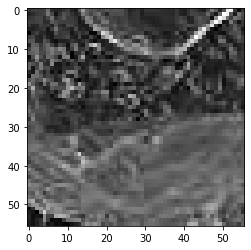

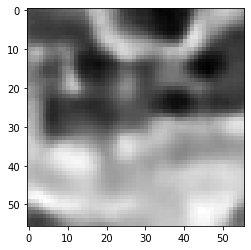

41.296108067035675

 next


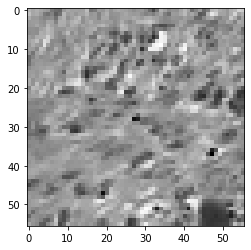

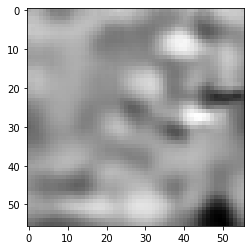

33.088822066783905

 next


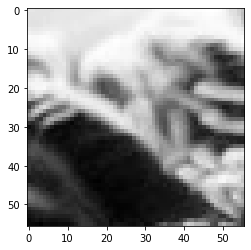

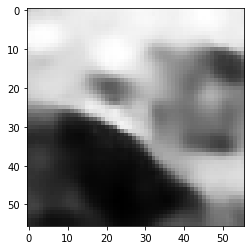

113.46255764365196

 next


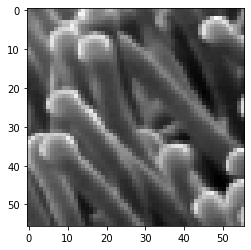

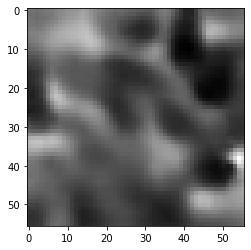

32.80848450958729

 next


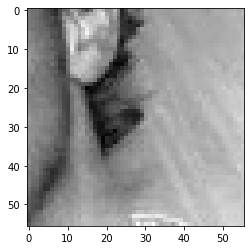

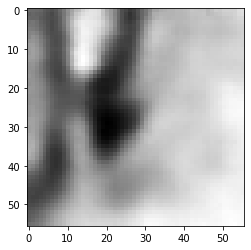

18.635429330170155

 next


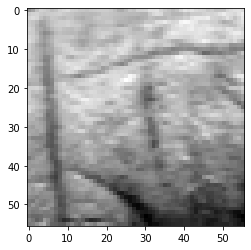

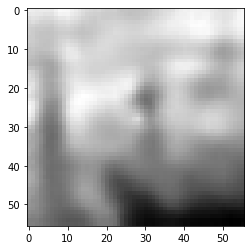

29.081988371908665

 next


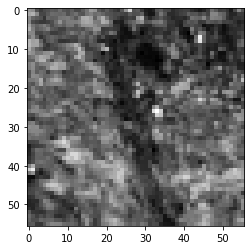

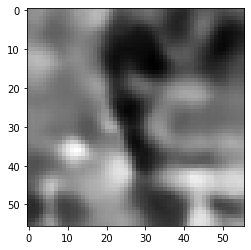

48.18134620785713

 next


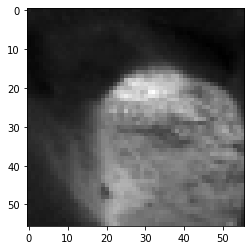

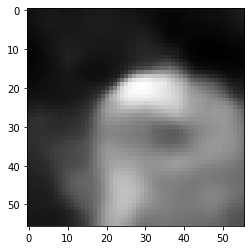

50.598841086030006

 next


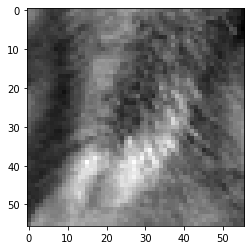

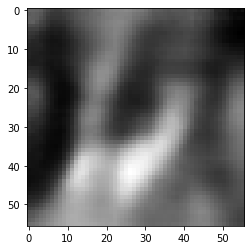

22.280113957822323

 next


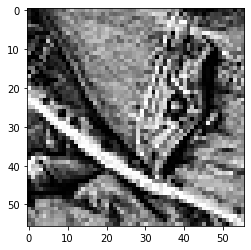

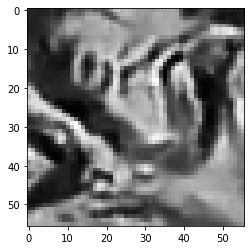

91.22831672430038

 next


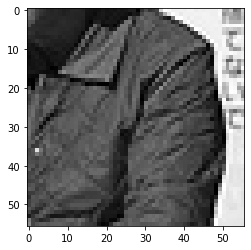

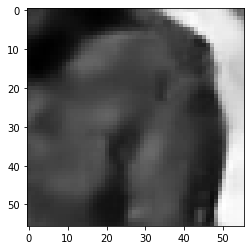

82.65332445502281

 next


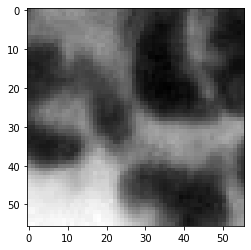

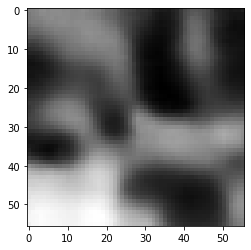

37.90891282260418

 next


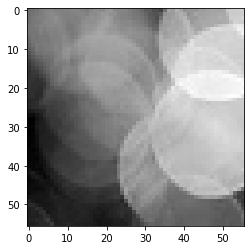

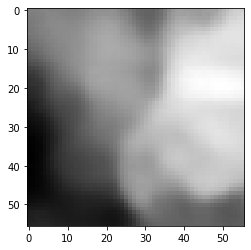

76.38801544904709

 next


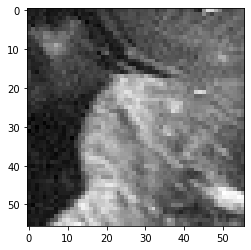

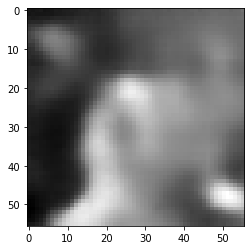

29.799705259501934

 next


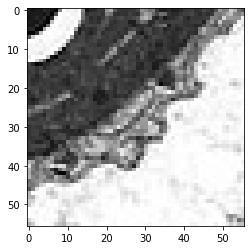

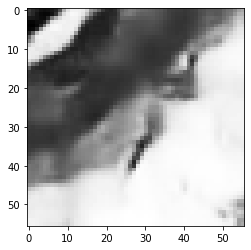

99.9745962023735

 next


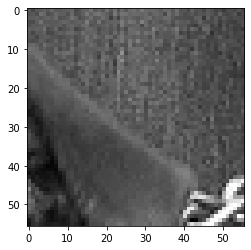

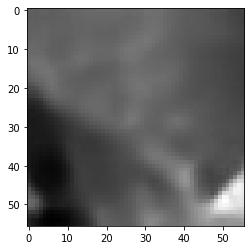

36.745548248291016

 next


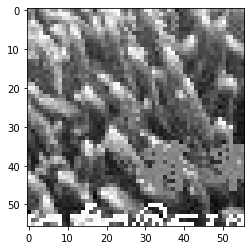

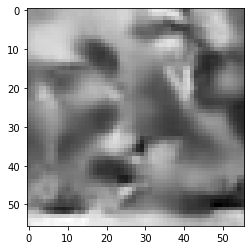

58.30504037439823

 next


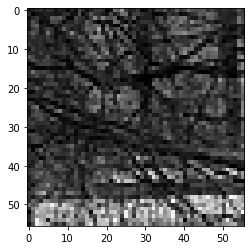

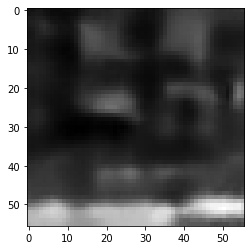

54.72965642809868

 next


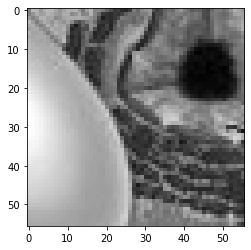

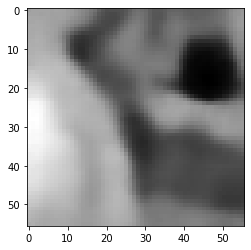

71.85045853257179

 next


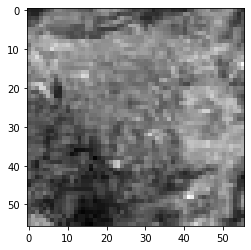

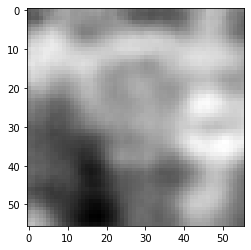

13.949143644422293

 next


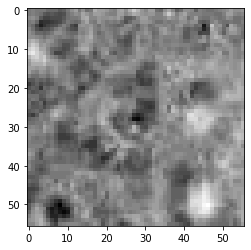

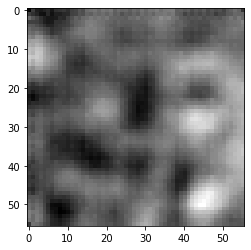

5.2815470192581415

 next


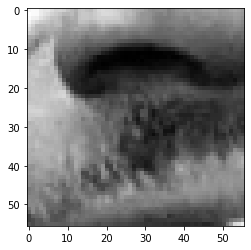

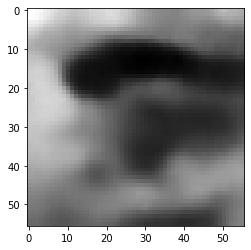

50.402064844965935

 next


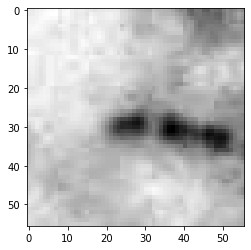

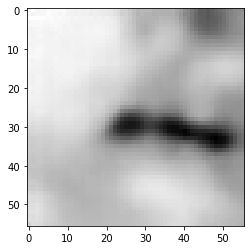

26.392078511416912

 next


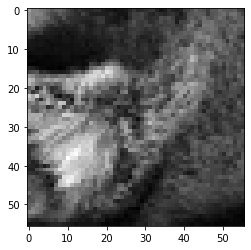

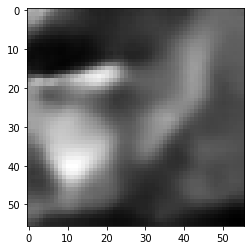

41.87844581902027

 next


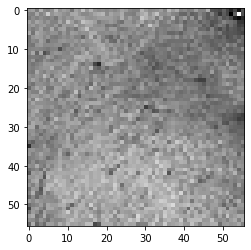

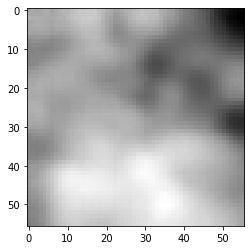

30.615988858044147

 next


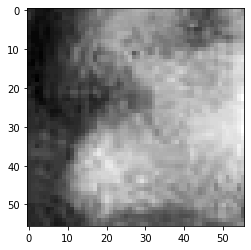

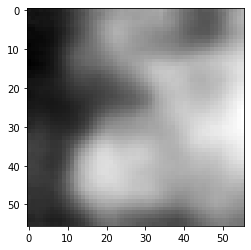

22.392907105386257

 next


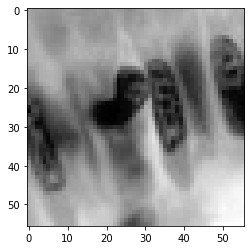

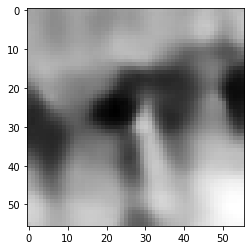

59.64947663247585

 next


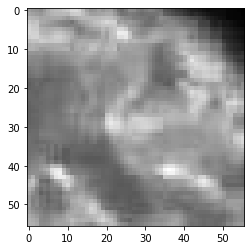

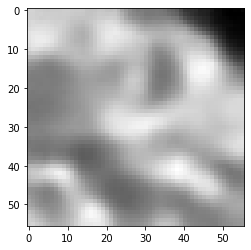

30.302613973617554

 next


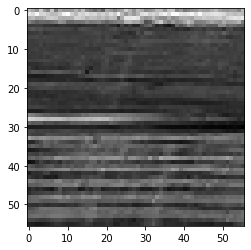

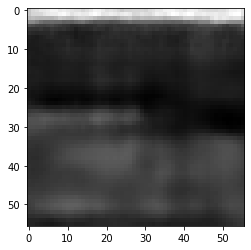

40.764455795288086

 next


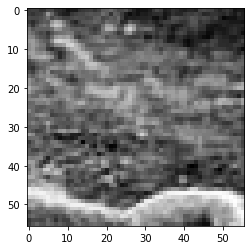

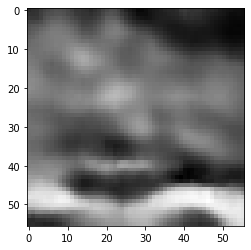

39.92569260299206

 next


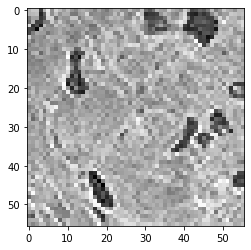

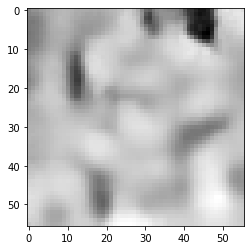

42.73135185241699

 next


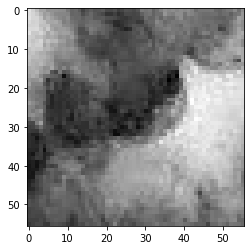

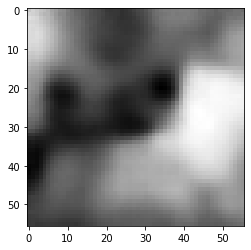

30.486193522810936

 next


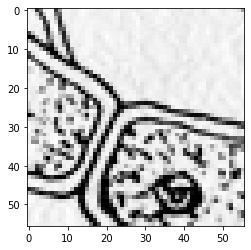

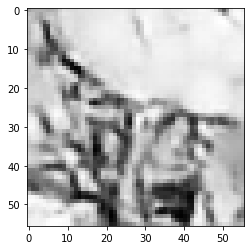

94.55931678414345

 next


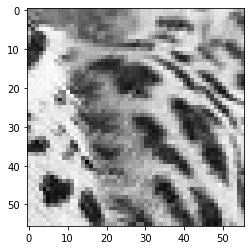

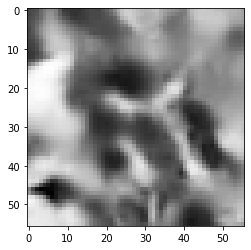

67.13867336511612

 next


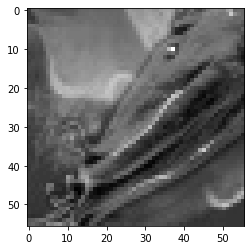

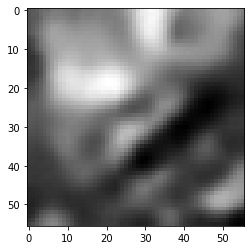

34.79503311216831

 next


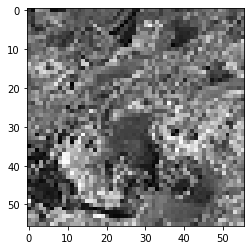

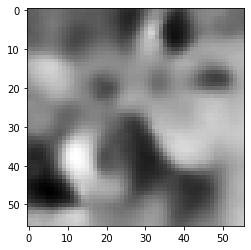

55.209392085671425

 next


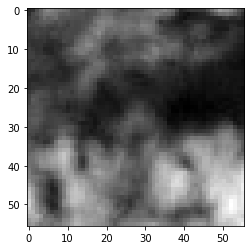

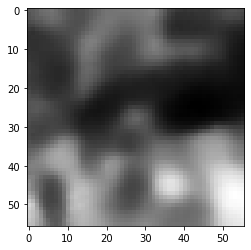

47.815813422203064

 next


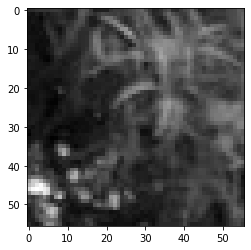

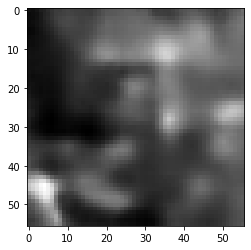

29.331262595951557

 next


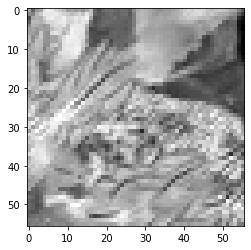

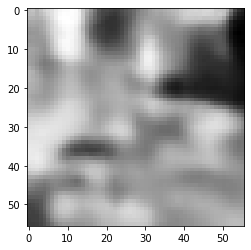

52.16976419091225

 next


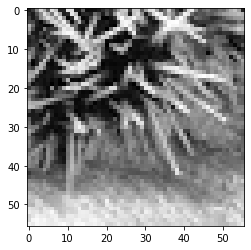

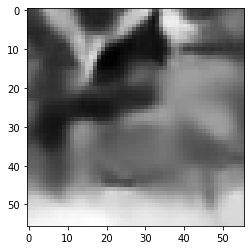

77.0843280851841

 next


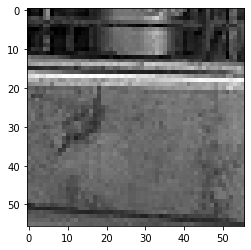

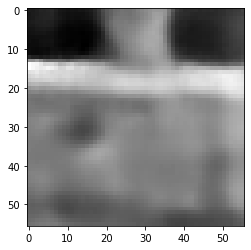

44.864534586668015

 next


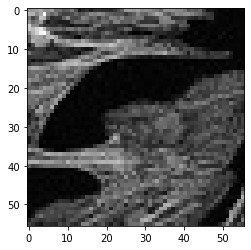

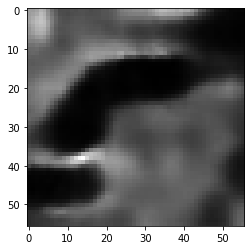

32.41416446864605

 next


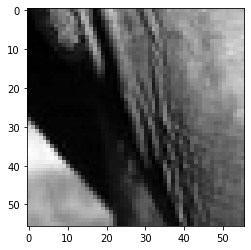

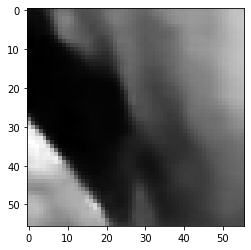

59.4593196362257

 next


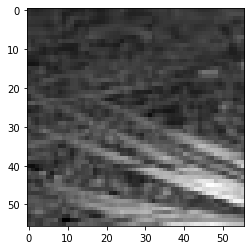

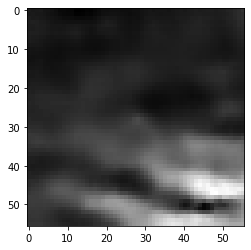

33.47509793937206

 next


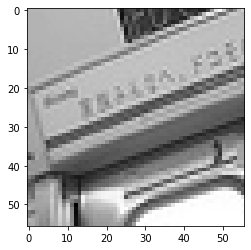

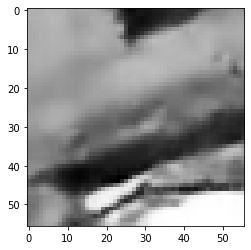

70.96438407897949

 next


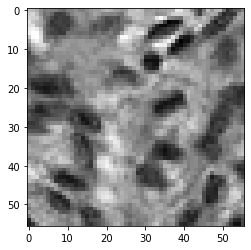

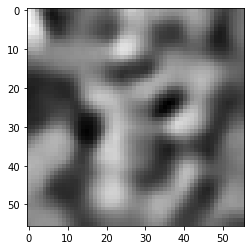

41.55534155666828

 next


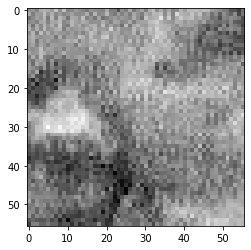

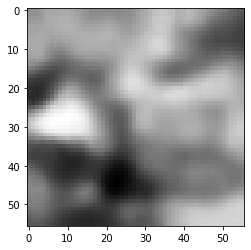

49.71262983977795

 next


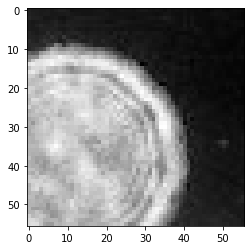

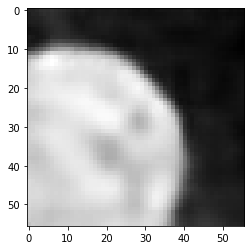

66.35275393724442

 next


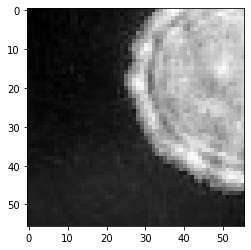

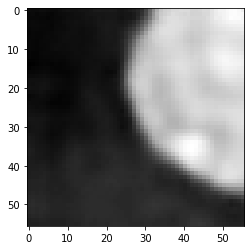

58.81074383854866

 next


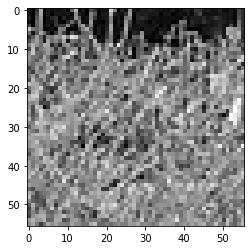

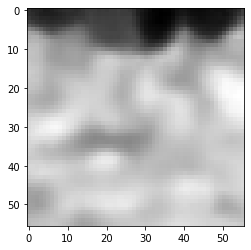

60.96166782081127

 next


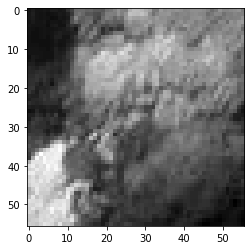

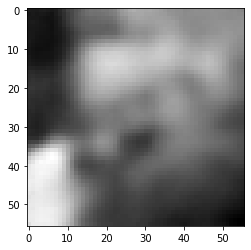

28.427538089454174

 next


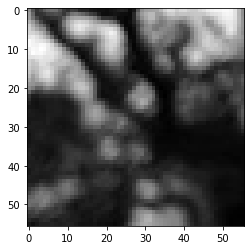

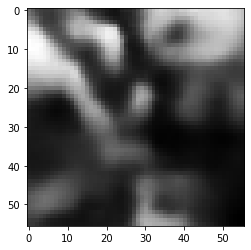

60.33846326172352

 next


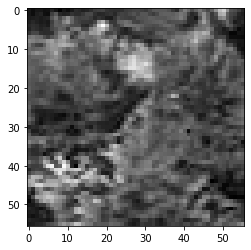

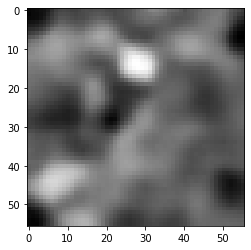

31.07044257223606

 next


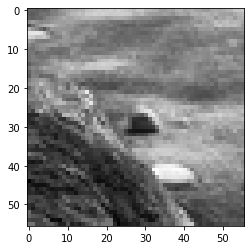

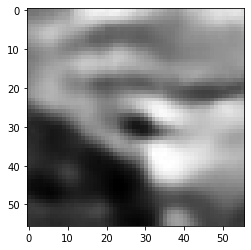

54.553604274988174

 next


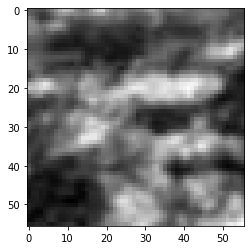

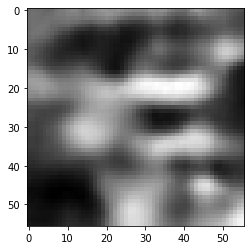

31.640873663127422

 next


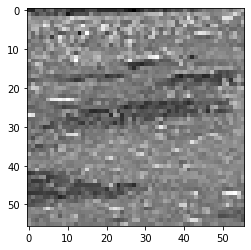

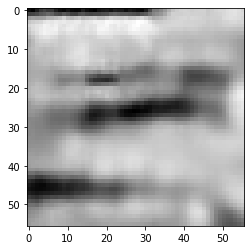

34.46146421134472

 next


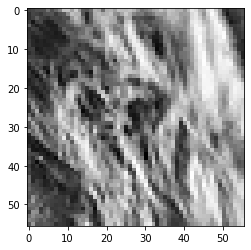

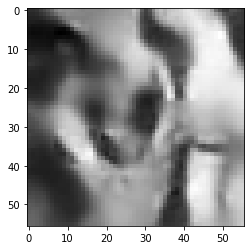

74.32787239551544

 next


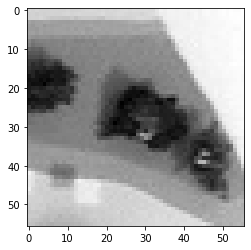

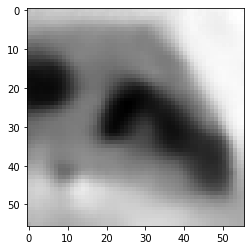

59.857040494680405

 next


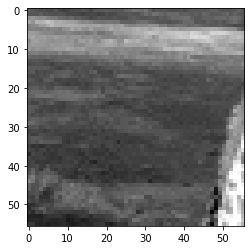

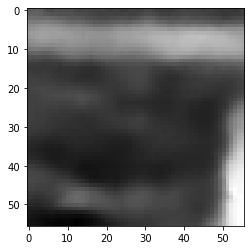

51.04724742472172

 next


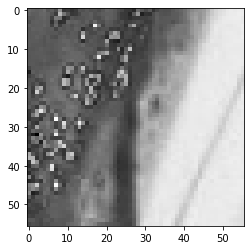

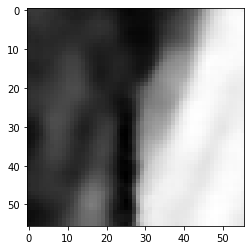

76.63769245147705

 next


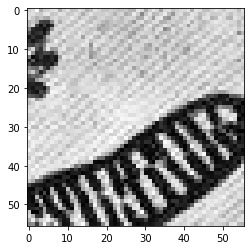

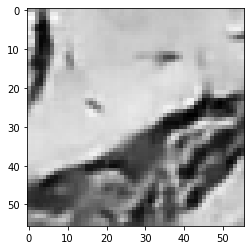

91.74131959676743

 next


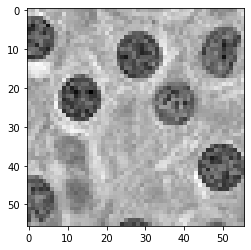

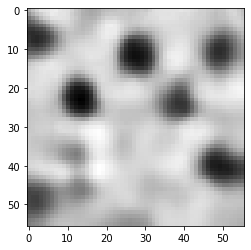

50.52998498082161

 next


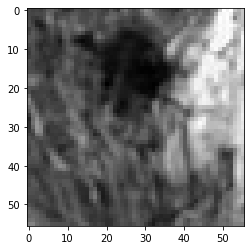

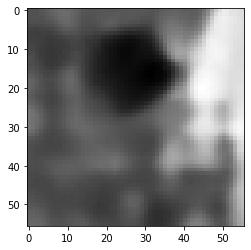

68.90196114778519

 next


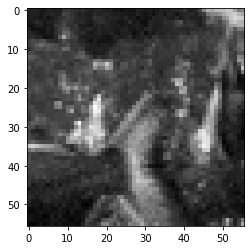

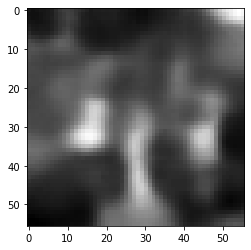

34.60146389901638

 next


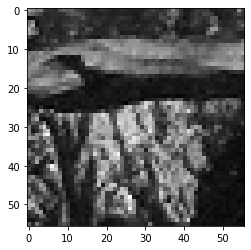

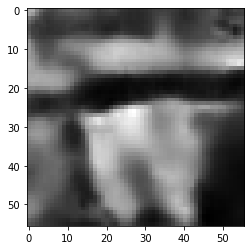

60.22970549762249

 next


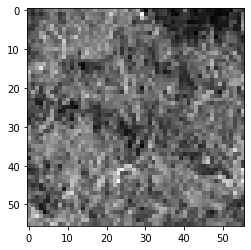

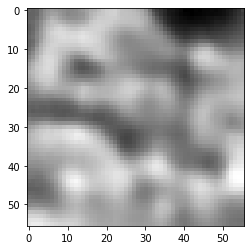

32.47232034802437

 next


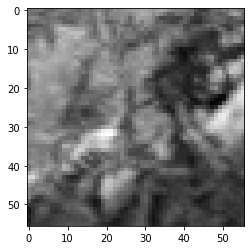

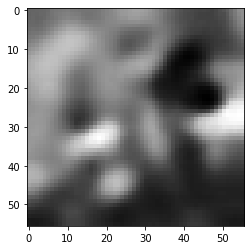

40.63713222742081

 next


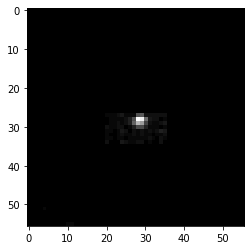

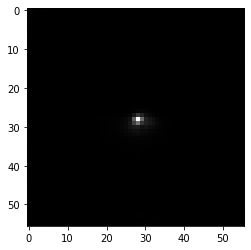

1.5075236256234348

 next


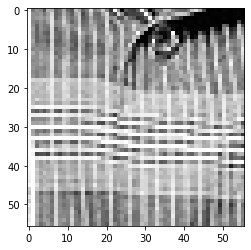

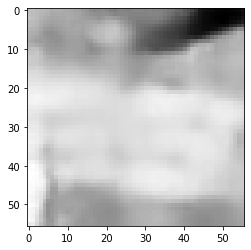

71.96034103631973

 next


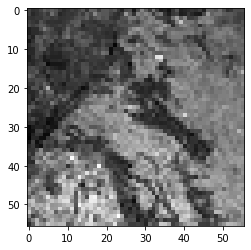

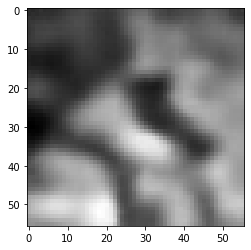

31.10480982810259

 next


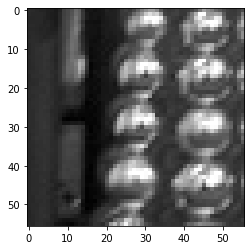

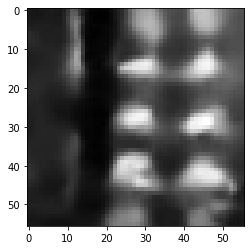

73.92202377319336

 next


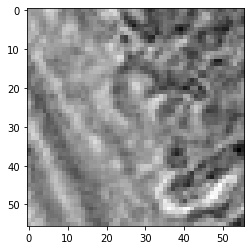

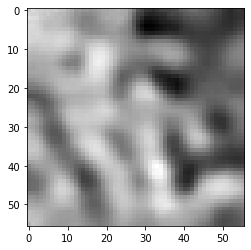

31.119948215782642

 next


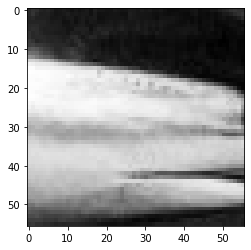

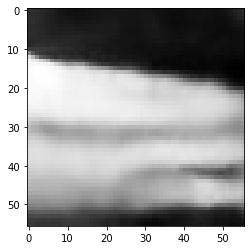

100.63965171575546

 next


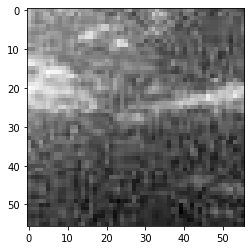

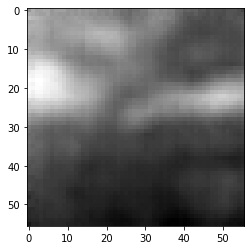

11.063382793217897

 next


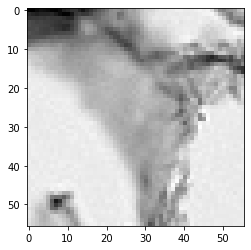

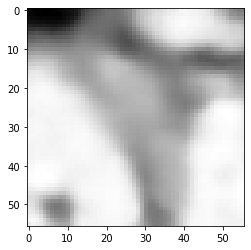

60.78506089746952

 next


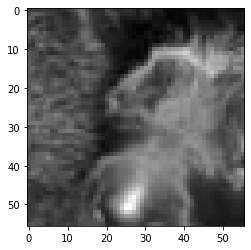

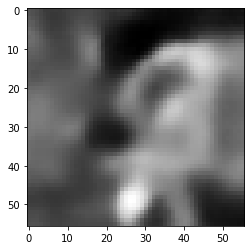

46.61516144871712

 next


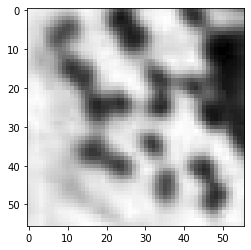

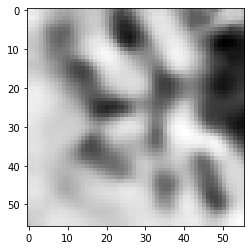

49.94010463356972

 next


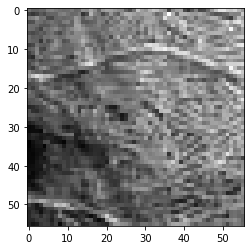

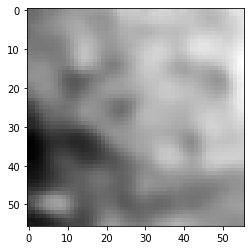

38.115956112742424

 next


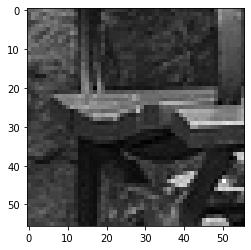

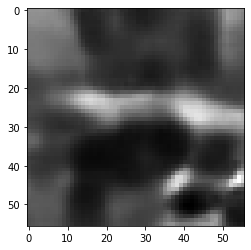

36.494355127215385

 next


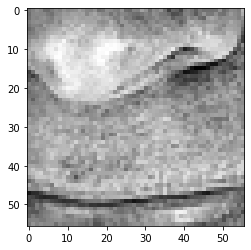

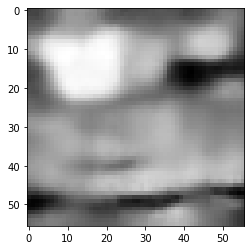

47.68659755587578

 next


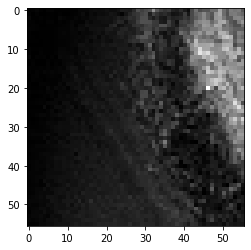

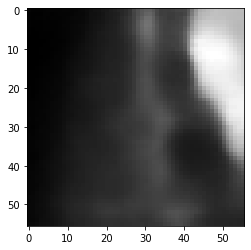

49.626944437623024

 next


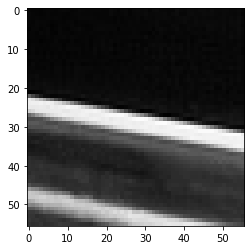

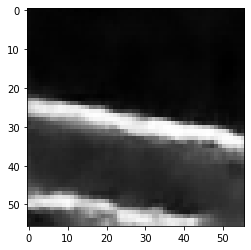

93.23497384786606

 next


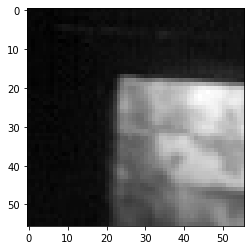

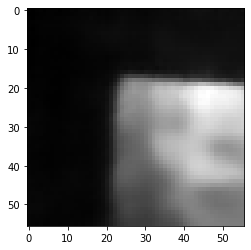

68.5871784389019

 next


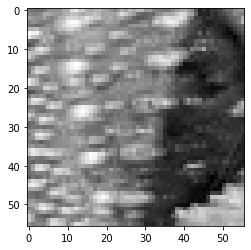

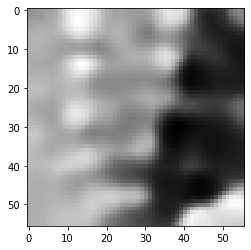

56.33895747363567

 next


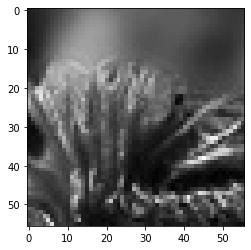

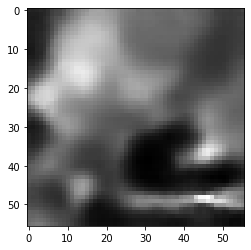

34.97830867767334

 next


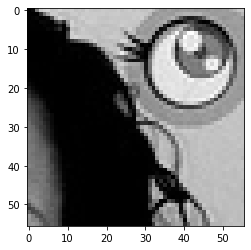

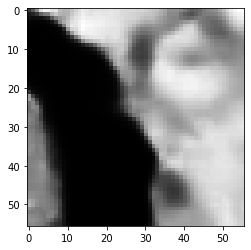

89.9719749391079

 next


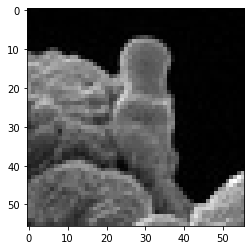

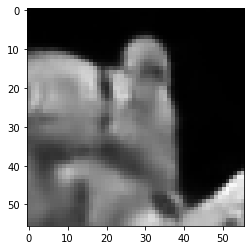

84.64529156684875

 next


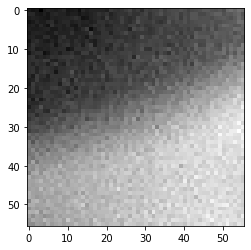

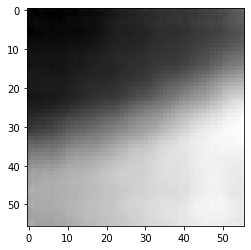

22.548932433128357

 next


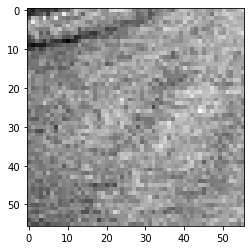

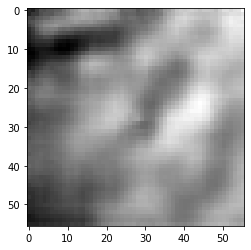

10.07635060697794

 next


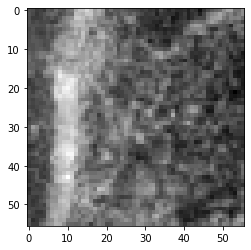

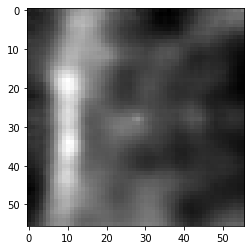

13.846823684871197

 next


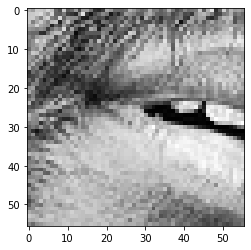

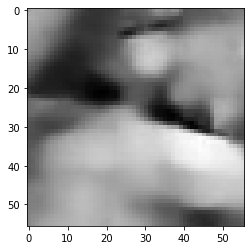

66.98388487100601

 next


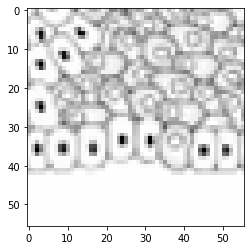

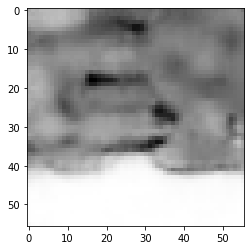

47.13006801903248

 next


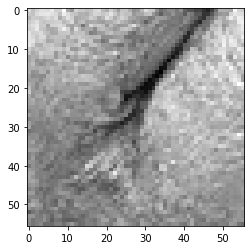

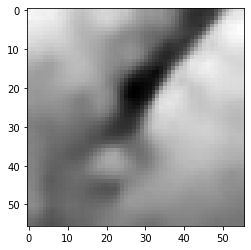

42.341800555586815

 next


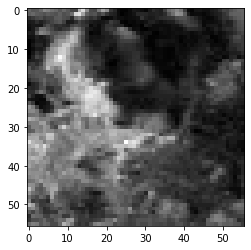

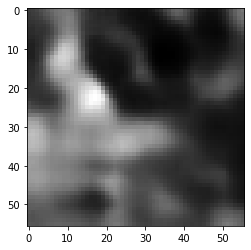

40.03753960132599

 next


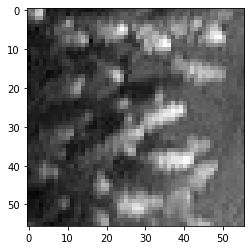

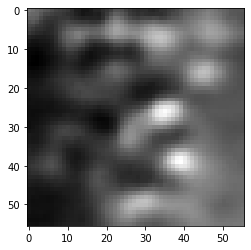

22.317475453019142

 next


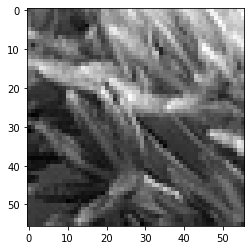

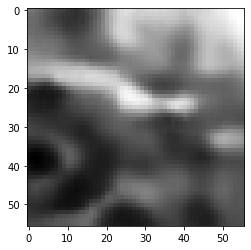

65.57001873850822

 next


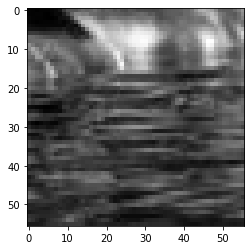

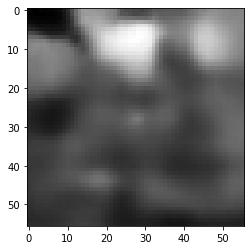

41.946853548288345

 next


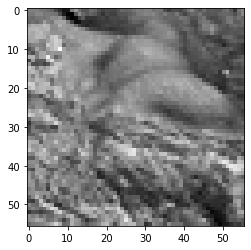

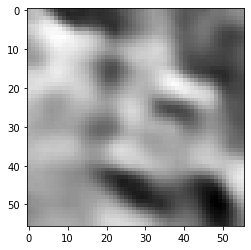

32.87661865353584

 next


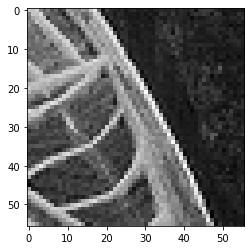

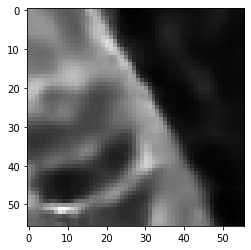

66.28099098801613

 next


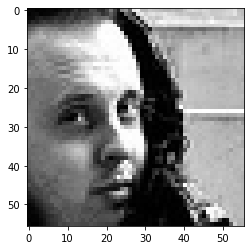

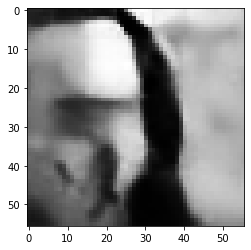

111.49778187274933

 next
0.19544051995966583


In [119]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(patch_size, patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], patch_size, patch_size, 1)
images = images / 255
predictions = decoder.predict_on_batch(encoder.predict_on_batch(np.array(images)))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape((patch_size, patch_size, 1))
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
#     ground_truth = im_1[5: 53, 5: 53, 0]
#     ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
#     plt.imshow(ground_truth[:, :], cmap='gray')
#     plt.show()
    
    
    pred_1 = predictions[i].reshape((patch_size, patch_size))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(im_1, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)

In [16]:
# vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam())

# history_callback = vae.fit(x_train, epochs=65*batch_size, batch_size=batch_size)

# model_version = "0.0.0.5"
# vae.save_weights(base_dir + '/vae_' + model_version + '.h5')


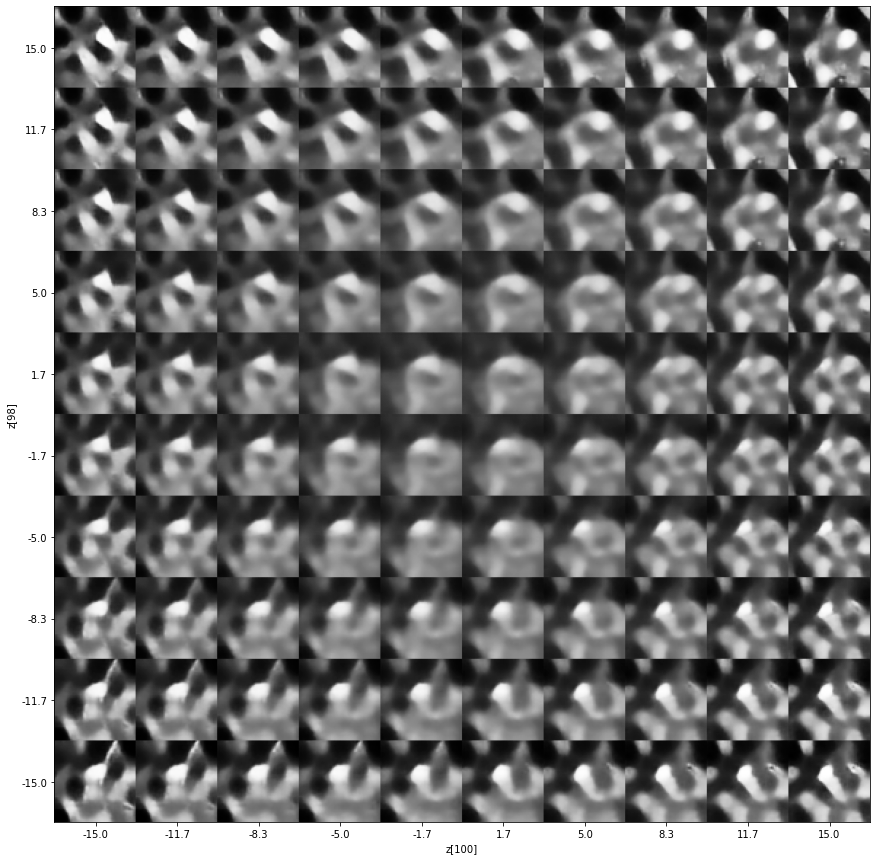

In [120]:
import matplotlib.pyplot as plt
import datetime

temp_patch = images[7]
temp_patches = np.expand_dims(temp_patch, axis=0)
temp_latent = encoder.predict_on_batch(np.array(temp_patches))
temp_latent[1] = np.zeros((1,128))
temp_latent[1] = np.zeros((1,128))


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 10
#     digit_size = 28
    scale = 15.0
    figsize = 15
    latent_dim_1 = 100
    latent_dim_2 = 98
    
    figure = np.zeros((patch_size * n, patch_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
#             z_sample = np.zeros(128)
#             z_sample[0] = xi
#             z_sample[1] = yi
#             z_sample = np.array([[xi, yi]])

#             temp_latent[0][0, 100: 110] = xi
#             temp_latent[0][0, 110: 120] = yi      
        
            temp_latent[0][0, latent_dim_1] = xi
            temp_latent[0][0, latent_dim_2] = yi

            x_decoded = decoder.predict_on_batch(temp_latent)
#             x_decoded = decoder.predict(z_sample)
            patch = x_decoded[0].reshape(patch_size, patch_size)
            figure[
                i * patch_size : (i + 1) * patch_size,
                j * patch_size : (j + 1) * patch_size,
            ] = patch

    plt.figure(figsize=(figsize, figsize))
    start_range = patch_size // 2
    end_range = n * patch_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, patch_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[" + str(latent_dim_1) + "]")
    plt.ylabel("z[" + str(latent_dim_2) + "]")
    plt.imshow(figure, cmap="Greys_r")
    plt.savefig('/home/niaki/Downloads/plot_latent_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '.pdf', dpi=600)
    plt.show()


plot_latent(encoder, decoder)

In [53]:
temp_patch = images[7]
temp_patches = np.expand_dims(temp_patch, axis=0)

In [54]:
temp_patches.shape

(1, 56, 56, 1)

In [95]:
temp_latent = encoder.predict_on_batch(np.array(temp_patches))
temp_latent[1] = np.zeros((1,128))
temp_latent[1] = np.zeros((1,128))

In [79]:
len(temp_latent)

3

In [80]:
temp_latent[2].shape

(1, 128)

In [84]:
temp_latent[1] = np.zeros((1,128))
temp_latent[1] = np.zeros((1,128))

In [60]:
decoder.predict_on_batch(temp_latent)

array([[[[0.24400112],
         [0.2365149 ],
         [0.24232244],
         ...,
         [0.41235375],
         [0.3975177 ],
         [0.3754317 ]],

        [[0.23852585],
         [0.23053616],
         [0.23075908],
         ...,
         [0.3990543 ],
         [0.38116273],
         [0.35413176]],

        [[0.23042269],
         [0.22102161],
         [0.22258809],
         ...,
         [0.3643447 ],
         [0.34636596],
         [0.32483688]],

        ...,

        [[0.24551053],
         [0.23941171],
         [0.24586353],
         ...,
         [0.33429125],
         [0.2911751 ],
         [0.29010016]],

        [[0.22226565],
         [0.21410182],
         [0.21406949],
         ...,
         [0.31308618],
         [0.27907914],
         [0.28336996]],

        [[0.22753353],
         [0.21256635],
         [0.21038157],
         ...,
         [0.31264767],
         [0.29381165],
         [0.29774904]]]], dtype=float32)